In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


from multiprocessing import Pool, shared_memory

import tensorflow as tf
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

MEMORY = 32*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

1 Physical GPUs, 1 Logical GPUs


In [2]:
from local_utils import *

# Load the parameters

In [3]:
import pandas as pd
df = pd.read_csv("../with_diffusions_second_search/df_network_analysis_full_topology_with_alienor_mesh_and_diffusion_estimates.csv")
df["index"] = range(df.shape[0])

In [4]:
def load_dataset(path, cont=False):
    if cont:
        with open(f"../{path[:-4]}_2", "rb") as f:
            k_max, params, res = np.load(f, allow_pickle=True)
    else:
        with open(f"../{path}", "rb") as f:
            k_max, params, res = np.load(f, allow_pickle=True)
    (n_val, 
     b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
     b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
     b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = params
    params = {
              'D_A':0.01,
              'D_B':1.0,
              'n':n_val, 
              'b_A':b_A_val, 
              'mu_A':mu_A_val, 
              'V_A':V_A_val,
              'K_AA':K_AA_val, 
              'K_AB':K_AB_val,  
              'K_AC':K_AC_val,
              'b_B':b_B_val, 
              'mu_B':mu_B_val, 
              'V_B':V_B_val,
              'K_BA':K_BA_val, 
              'K_BC':K_BC_val,  
              'b_C':b_C_val, 
              'mu_C':mu_C_val, 
              'V_C':V_C_val,
              'K_CB':K_CB_val, 
              'K_CC':K_CC_val
             }
           
    return (params, res, k_max)

# def load_dataset(index):
#     with open(f"./outputs/parameters_100_{index}.npy", "rb") as f:
#         params = np.load(f)
#     (n_val, 
#      b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
#      b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
#      b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = params
#     params = {
#               'D_A':0.01,
#               'D_B':1.0,
#               'n':n_val, 
#               'b_A':b_A_val, 
#               'mu_A':mu_A_val, 
#               'V_A':V_A_val,
#               'K_AA':K_AA_val, 
#               'K_AB':K_AB_val,  
#               'K_AC':K_AC_val,
#               'b_B':b_B_val, 
#               'mu_B':mu_B_val, 
#               'V_B':V_B_val,
#               'K_BA':K_BA_val, 
#               'K_BC':K_BC_val,  
#               'b_C':b_C_val, 
#               'mu_C':mu_C_val, 
#               'V_C':V_C_val,
#               'K_CB':K_CB_val, 
#               'K_CC':K_CC_val
#              }
        
#     with open(f"./outputs/full_solution_100_{index}.npy", "rb") as f:
#         res_128_50 = np.load(f)
#     with open(f"./outputs/full_solution_10_{index}.npy", "rb") as f:
#         res_128_10= np.load(f)
#     with open(f"./outputs/full_solution_1_{index}.npy", "rb") as f:
#         res_128_1 = np.load(f)
#     return (params, res_128_50, res_128_10, res_128_1)

10 outputs_second_search/solution_10_10_103.npy
index                                                              10
type                                                             spot
estimated_params    (0.9998756872706421, 6.797751713112303, 10.097...
original_params                         (1.0, 100.0, 10.0, 5.0, 10.0)
euclidian_dist                                              93.329735
search_alg                                                   L_BFGS_B
Has_closer_est                                                   True
Name: 10, dtype: object
bad_estimates                          2
list_of_bad_estimates    ('V_C', 'K_CC')
Name: 10, dtype: object
bad_estimates_A_alienor_mesh                                  2
list_of_bad_estimates_A_alienor_mesh             ('D_A', 'b_A')
bad_estimates_B_alienor_mesh                                  3
list_of_bad_estimates_B_alienor_mesh     ('b_B', 'V_B', 'K_CB')
bad_estimates_C_alienor_mesh                                  3
list_of_bad_

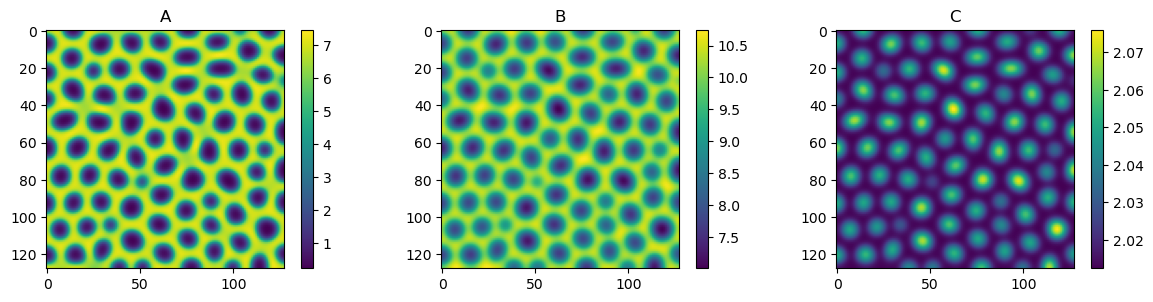

In [5]:
index = 10#2

print(index, df.iloc[index]["path"])
print(df.iloc[index][df.columns[40:47]])
print(df.iloc[index][df.columns[63:65]])
print(df.iloc[index][df.columns[-6:]])
params, res, k_max = load_dataset(df.iloc[index]["path"])

def to(arr):
    return arr.reshape(128, 128) 

def reshape(arr, steps=1):
    T = arr.shape[0]
    ret = np.array([
        [to(arr[i, 0, :]), to(arr[i, 1, :]), to(arr[i, 2, :])]
        for i in range(T-steps, T)
    ])
    return np.einsum("tcxy -> cxyt", ret)


plot_n_im([to(res[-1, 0, :]), to(res[-1, 1, :]), to(res[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

In [6]:
T=1
L=10


data = reshape(res, T)#res_128_1[:, :, :, np.newaxis]
nodes_n = data.shape[0]
node_names = ["A", "B", "C"]
x_size = data.shape[1]
y_size = data.shape[2]

##########################################
# Create a mesh that is the centers of the
# original mesh
x_size -= 1
y_size -= 1

dxdy = L**2/((x_size-1)*(y_size-1))
N = x_size*y_size    
t_star = np.arange(T, T+1)

##########################
# select a subset of data
#t_star = t_star[-4:]
#T = len(t_star)
#data = data[:, :, :, -4::]
x_slice = slice(65, 100, 1)
y_slice = slice(65, 100, 1)


# x_slice = slice(0, x_size, 1)
# y_slice = slice(0, x_size, 1)


x_range = L * np.linspace(0, 1, x_size)[x_slice]
y_range = L * np.linspace(0, 1, y_size)[y_slice]

block_x = x_range.shape[0]
block_y = y_range.shape[0]

x = tf.constant(x_range, dtype=tf.float32)
y = tf.constant(y_range, dtype=tf.float32)


# The order of the Y and X must be reversed,
# since the chnages the value finds the derivatives
#Y, X = tf.meshgrid(x, y)

X, Y = tf.meshgrid(x, y)
ts = tf.constant(t_star, dtype=tf.float32)
T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(X.shape)[:, :, tf.newaxis]
def H_cube(X, Y, T):
    return tf.concat(
            [
                tf.concat(
                    [
                        X[tf.newaxis, :, :, tf.newaxis],
                        Y[tf.newaxis, :, :, tf.newaxis],
                        T[:, :, i : i + 1][tf.newaxis, :, :, :],
                    ],
                    axis=3,
                )
                for i in range(T.shape[-1])
            ],
            axis=0,
        )
H = H_cube(X, Y, T)
########################################
# Take the average of data points
kernel =np.array([[1, 1],
                  [1, 1]])


data2 = np.stack([[ (ndimage.convolve(data[i, :, :, j], kernel)/4)[x_slice, y_slice] 
                        for j in  range(data.shape[3])]
                        for i in  range(data.shape[0])])
data2 = np.einsum("ctxy -> cxyt", data2)


In [1]:
plt.figure(figsize=(12, 3))
for i in range(3):
    plt.subplot(1,3, i+1)
    plt.imshow(data[i, :, :, -1])
    plt.colorbar()
plt.tight_layout();plt.show()

plt.figure(figsize=(12, 3))
for i in range(3):
    plt.subplot(1,3, i+1)
    plt.imshow(data[i, :, :, -1])
    plt.colorbar()
plt.tight_layout();plt.show()


# plt.figure(figsize=(12, 3))
# for i in range(3):
#     plt.subplot(1,3, i+1)
#     plt.imshow(data2[i, x_slice, y_slice, -1])
#     plt.colorbar()
# plt.tight_layout();plt.show()

NameError: name 'plt' is not defined

In [101]:
# print(np.min(data2[0, x_slice, y_slice, -1]), np.max(data2[0, x_slice, y_slice, -1]))
# print(np.min(data2[1, x_slice, y_slice, -1]), np.max(data2[1, x_slice, y_slice, -1]))
# print(np.min(data2[2, x_slice, y_slice, -1]), np.max(data2[2, x_slice, y_slice, -1]))

In [102]:
127*127

16129

In [103]:
H.shape

TensorShape([1, 35, 35, 3])

In [104]:
data2.shape

(3, 35, 35, 1)

In [8]:
c = data2.copy()#data2[:, x_slice, y_slice, :].copy()
def gen_series():    
    
    for i in range(H.shape[0]):        
        yield H[i, ...], np.einsum( "cxy -> xyc", c[..., i]) 
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32), 
                                    output_shapes=((H.shape[1],H.shape[2], H.shape[3]),
                                                   (c.shape[1],c.shape[2], c.shape[0])))

In [9]:
c.shape

(3, 35, 35, 1)

In [10]:
def clip_by_value_zero_lb(z):
        return tf.clip_by_value(z, 0, 1e10,)
    
class tf_param:
    def __init__(self, name, value=None, is_constant=True):
        self.name = name
        if value is None:
            self.value = params[name]
        else:
            self.value = value
        self.is_constant = is_constant    

class NN_2_res(tu.NN_base):
    def __init__(self, layers, lb, ub, dtype=tf.float32, res_len=2, **kwargs):
        """A dense Neural Net that is specified by layers argument.

        layers: input, dense layers and outputs dimensions
        lb    : An array of minimums of inputs (lower bounds)
        ub    : An array of maximums of inputs (upper bounds)
        """
        super().__init__(dtype, **kwargs)
        self.layers = layers
        self.num_layers = len(self.layers)
        self.lb = lb
        self.ub = ub
        self.res_len = res_len
        self.build()

    def create_1_unit_layer(self, layers):
        weights = []
        biases = []
        for i in range(0, self.num_layers - 1):
            W = self.xavier_init(size=[layers[i], layers[i + 1]])
            #W = tf.Variable(tf.ones([layers[i], layers[i + 1]], dtype=self.dtype)/(layers[i]+layers[i + 1]),
            #                dtype=self.dtype)
            b = tf.Variable(tf.zeros([1, layers[i + 1]], dtype=self.dtype), dtype=self.dtype)
            weights.append(W)
            biases.append(b)
        return weights, biases 
    def build(self):
        """Create the state of the layers (weights)"""
        self.Ws_layers = []
        self.bs_layers = []
        for i in range(self.res_len):
            Ws, bs = self.create_1_unit_layer(self.layers)
            self.Ws_layers.append(Ws)
            self.bs_layers.append(bs)
        

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(
            tf.compat.v1.truncated_normal([in_dim, out_dim], stddev=xavier_stddev, dtype=self.dtype), dtype=self.dtype
        )

    def net_1_layer(self, Ws, bs, H):
        for W, b in zip(Ws[:-1], bs[:-1]):
            H = tf.nn.tanh(tf.add(tf.matmul(H, W), b))
        W = Ws[-1]
        b = bs[-1]
        outputs = tf.add(tf.matmul(H, W), b)
        return outputs
        
    @tf.function
    def net(self, inputs):
        # Map the inputs to the range [-1, 1]
        H1 = 2.0 * (inputs - self.lb) / (self.ub - self.lb) - 1.0
        H1 = self.net_1_layer(self.Ws_layers[0], self.bs_layers[0], H1)
        for i in range(1, self.res_len):
            H1 = tf.nn.tanh(H1)
            H2 = self.net_1_layer(self.Ws_layers[i], self.bs_layers[i], H1)
            H1 += H2
        
#         H1 = tf.nn.tanh(H1)
#         H2 = self.net_1_layer(self.Ws_layers[-1], self.bs_layers[-1], H1)
#         return H2
        return H1


    def __call__(self, inputs):
        """Defines the computation from inputs to outputs

        Args:
           inputs: A tensor that has a shape [None, D1], where
                   D1 is the input dimensionality, specified in
                   the first element of layes.

        Return:
                A tensor of the dense layer output that has a shape
                [None, Dn], where Dn is the dimensionality of the last
                layer, specificed by the last elements of the layer
                arguemnt.
        """
        X = tf.cast(inputs, self.dtype)
        return self.net(X)

    def gradients(self, inputs, outputs):
        """finds the first and second order griadients of outputs at inputs

        Args:
           inputs: A tensor that has a shape [None, D1], where
                   D1 is the input dimensionality, specified in
                   the first element of layes.
           outputs:  A tensor that has a shape [None, Dn], where
                   Dn is the output dimensionality, specified in
                   the last element of layes.

        Return:   The returns 'partial_1' and 'partial_2' are the first and second
                  order gradients, repsectivly. Each one is a list that its elements
                  corresponds to one of the NN's last layer output. e.g. if the last layer
                  has Dn outputs, each list has Dn tensors as an elements. The dimensionality
                  of the tensors are the same as inputs: [None, D1]

        """
        partials_1 = [tf.gradients(outputs[:, i], inputs)[0] for i in range(outputs.shape[1])]
        partials_2 = [tf.gradients(partials_1[i], inputs)[0] for i in range(outputs.shape[1])]
        return partials_1, partials_2

    def gradients_tape(self, inputs, outputs, tape):
        """finds the first and second order griadients of outputs at inputs

        Args:
           inputs: A tensor that has a shape [None, D1], where
                   D1 is the input dimensionality, specified in
                   the first element of layes.
           outputs:  A tensor that has a shape [None, Dn], where
                   Dn is the output dimensionality, specified in
                   the last element of layes.
           tape:   Gradient Tape object, for eager mode.
                   The outputs must be the list
                   of Tensors.

        Return:   The returns 'partial' gradients. It is a list that its elements
                  corresponds to one of the NN's last layer output. e.g. if the last layer
                  has Dn outputs, the list has Dn tensors as an elements. The dimensionality
                  of the tensors is the same as inputs: [None, D1]

        """
        partials = [tape.gradient(outputs[i], inputs) for i in range(len(outputs))]
        return partials

def create_pinn(layers=[3, 512, 512, 3], res_len = 2,
                learning_rate=1e-2,                
                w1=1, w2=1, w3=1): 
    # Since there is just one time step, the lower bound is zero and the upper bound is one
    lb = tf.constant([x_range[0], y_range[0], 0], dtype=tf.float32)
    ub =  tf.constant([x_range[-1], y_range[-1], t_star[0]], dtype=tf.float32)    
    pinn = tu.NN_Scaled(layers, lb, ub, tf.float32)
    #pinn = NN_2_res(layers, lb, ub, tf.float32, res_len)
    #optimizer=keras.optimizers.Adam(learning_rate=1e-2)   
    #optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate)
                       
    w1 = tf.Variable(w1,dtype=pinn.dtype,name="w1")
    w2 = tf.Variable(w2,dtype=pinn.dtype,name="w2")
    w3 = tf.Variable(w3,dtype=pinn.dtype,name="w3")
        

    #@tf.function
    def train_step_inverse(elements):
        def flatten(arr):
            return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))
        
        
        
        with tf.GradientTape(persistent=False) as tape: 
            H = elements[0]
            # remove the boundaries
            #H = H[:, 1:-1, 1:-1, :]               
            H = flatten(H)
            tape.watch(H)
            trainables = pinn.trainable_variables 

            outputs = pinn.net(H)
            Ag = tf.squeeze(outputs[:, 0])
            Bg = tf.squeeze(outputs[:, 1])
            Cg = tf.squeeze(outputs[:, 2])
            
            H2 = elements[1]
            # remove the boundaries
            #H2 = H2[:, 1:-1, 1:-1, :]
            H2 = flatten(H2)
            A = tf.squeeze(H2[:, 0])
            B = tf.squeeze(H2[:, 1])
            C = tf.squeeze(H2[:, 2])                
           
            
            l2_res_A = tf.reduce_mean((A - Ag)**2)
            l2_res_B = tf.reduce_mean((B - Bg)**2)
            l2_res_C = tf.reduce_mean((C - Cg)**2)            


            l2 = (w1*l2_res_A + w2*l2_res_B + w3*l2_res_C)
        
        grads = tape.gradient(l2, trainables)
        #print(tf.reduce_mean([tf.reduce_mean(g) for g in grads]))
        optimizer.apply_gradients(zip(grads, trainables))
        return (l2_res_A, l2_res_B, l2_res_C)
    
    names = ['l2_res_A', 'l2_res_B', 'l2_res_C']

    def print_callback(printer, losses, epoch):

        printer(f"at epoch {epoch:d}, total loss: {np.sum(losses)}, rmse loss: {np.sqrt(np.sum(losses))}")
        printer(", ".join([f"{n}: {v:.8f}" for n,v in zip(names, losses)]))         
        #printer(", ".join([f"{par.name}: {par.numpy()}" for par in params_trainable]))
    
    return (pinn, optimizer, train_step_inverse, names, print_callback,
            w1, w2, w3)

In [161]:
(pinn1, optimizer1, train_step_inverse1,names, print_callback1,
w1, w2, w3) = create_pinn(layers=[3, 1024,1024,1024, 3],learning_rate=1e-2,res_len=4, w1=1, w2=1, w3=1)

#(b_A, b_B, b_C, V_A, V_B, V_C, mu_A, mu_B, mu_C) = params_trainable1
#(b_A, b_B, b_C, V_A, V_B, V_C) = params_trainable1
#(b_A, b_B, b_C, V_C) = params_trainable1
#(b_C, V_C) = params_trainable1

In [157]:
#pinn1 = tu.NN_Scaled.restore(".","temp_pinn")

In [158]:
H.shape[1]*H.shape[2]/5

245.0

In [162]:
losses1 = tu.train(epochs=3*1000,
                  batch_size=H.shape[1]*H.shape[2],#//5,
                  dataset = ds,#ds.shuffle(H.shape[1]*H.shape[2]),
                  train_step = train_step_inverse1,
                  train_step_returns_num = 3,
                  print_interval=1000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-4,
                  print_callback = print_callback1,
                  epoch_callback=None,
                  stop_condition=None)
optimizer1.lr.assign(1e-3)
losses2 = tu.train(epochs=10000,
                  batch_size=H.shape[1]*H.shape[2],#//5,
                  dataset = ds,#ds.shuffle(H.shape[1]*H.shape[2]),
                  train_step = train_step_inverse1,
                  train_step_returns_num = 3,
                  print_interval=1000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-4,
                  print_callback = print_callback1,
                  epoch_callback=None,
                  stop_condition=None)
optimizer1.lr.assign(1e-4)
losses3 = tu.train(epochs=20000,
                  batch_size=H.shape[1]*H.shape[2],#//5,
                  dataset = ds,#ds.shuffle(H.shape[1]*H.shape[2]),
                  train_step = train_step_inverse1,
                  train_step_returns_num = 3,
                  print_interval=1000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-4,
                  print_callback = print_callback1,
                  epoch_callback=None,
                  stop_condition=None)


Start of epoch 0
at epoch 0, total loss: 121.12644863128662, rmse loss: 11.005746164221971
l2_res_A: 27.69187737, l2_res_B: 89.57389832, l2_res_C: 3.86067295
Time taken: 0.99s

Start of epoch 1000
at epoch 1000, total loss: 3.7507637068629265, rmse loss: 1.9366888513292284
l2_res_A: 2.48724365, l2_res_B: 1.19939482, l2_res_C: 0.06412523
Time taken: 27.16s

Start of epoch 2000
at epoch 2000, total loss: 1.7033691163524054, rmse loss: 1.3051318386861939
l2_res_A: 0.89730966, l2_res_B: 0.80549020, l2_res_C: 0.00056926
Time taken: 28.61s

Start of epoch 0
at epoch 0, total loss: 1.2051940723904409, rmse loss: 1.0978133139976218
l2_res_A: 0.52356851, l2_res_B: 0.68108398, l2_res_C: 0.00054158
Time taken: 0.08s

Start of epoch 1000
at epoch 1000, total loss: 0.04511888617707882, rmse loss: 0.2124120669290679
l2_res_A: 0.02495842, l2_res_B: 0.02014397, l2_res_C: 0.00001649
Time taken: 27.06s

Start of epoch 2000
at epoch 2000, total loss: 0.036577802774445445, rmse loss: 0.19125324252008238


In [ ]:
Start of epoch 19000
at epoch 19000, total loss: 0.0024247526771432604, rmse loss: 0.04924177776180771
l2_res_A: 0.00129913, l2_res_B: 0.00111759, l2_res_C: 0.00000804
Time taken: 24.60s

In [23]:
H.shape[1],H.shape[2], H.shape[1]*H.shape[2], H.shape[1]*H.shape[2]/3

(126, 126, 15876, 5292.0)

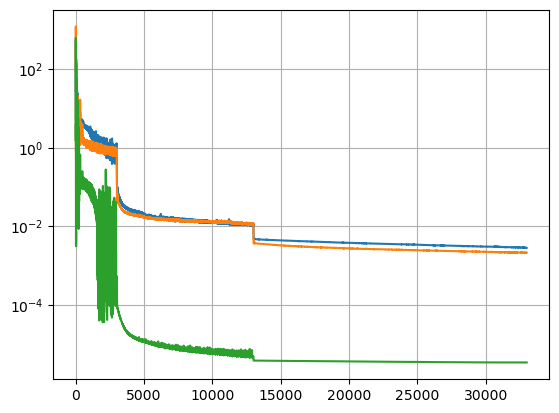

In [163]:
plt.plot(np.r_[losses1, losses2, losses3])
plt.yscale('log');plt.grid();plt.show()

In [220]:
losses4 = tu.train(epochs=20000,
                  batch_size=H.shape[1]*H.shape[2],#//5,
                  dataset = ds,#ds.shuffle(H.shape[1]*H.shape[2]),
                  train_step = train_step_inverse1,
                  train_step_returns_num = 3,
                  print_interval=1000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-4,
                  print_callback = print_callback1,
                  epoch_callback=None,
                  stop_condition=None)


Start of epoch 0
at epoch 0, total loss: 0.004935763579851482, rmse loss: 0.0702549897149767
l2_res_A: 0.00279707, l2_res_B: 0.00213528, l2_res_C: 0.00000342
Time taken: 0.21s

Start of epoch 1000
at epoch 1000, total loss: 0.004841188119598883, rmse loss: 0.06957864700897023
l2_res_A: 0.00272531, l2_res_B: 0.00211247, l2_res_C: 0.00000341
Time taken: 25.76s

Start of epoch 2000
at epoch 2000, total loss: 0.004758775647133007, rmse loss: 0.06898387961787164
l2_res_A: 0.00269833, l2_res_B: 0.00205705, l2_res_C: 0.00000340
Time taken: 25.83s

Start of epoch 3000
at epoch 3000, total loss: 0.004670772292001857, rmse loss: 0.06834304860043819
l2_res_A: 0.00263460, l2_res_B: 0.00203278, l2_res_C: 0.00000339
Time taken: 25.96s

Start of epoch 4000
at epoch 4000, total loss: 0.004589693975276532, rmse loss: 0.06774728020575094
l2_res_A: 0.00258968, l2_res_B: 0.00199664, l2_res_C: 0.00000338
Time taken: 24.97s

Start of epoch 5000
at epoch 5000, total loss: 0.004528198195203004, rmse loss: 0.

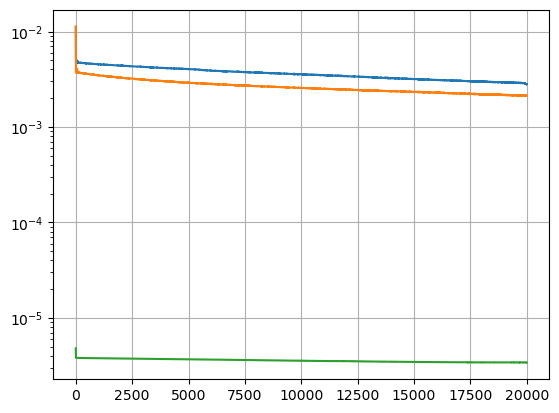

In [219]:
plt.plot(np.r_[ losses3])
plt.yscale('log');plt.grid();plt.show()

In [ ]:
#Start of epoch 40000
#at epoch 40000, total loss: 0.09473658924798656
#l2_res_A: 0.07312288, l2_res_B: 0.02160452, l2_res_C: 0.00000919
#Time taken: 44.64s

In [11]:
pinn1 =tu.NN_base.restore(".","temp_pinn")

In [12]:
x_range_test = L * (np.linspace(0, 1, x_size) - 2/x_size)[x_slice]
y_range_test = L * (np.linspace(0, 1, y_size) - 2/y_size)[y_slice]
X_test, Y_test = np.meshgrid(x_range_test, y_range_test)
ts_test = np.array(t_star, dtype=np.float32)
T_test = ts_test[np.newaxis, np.newaxis, :] * np.ones(X_test.shape)[:, :, np.newaxis]
H_test = H_cube(X_test, Y_test, T_test)
H_test = H_test.numpy().astype(np.float32)

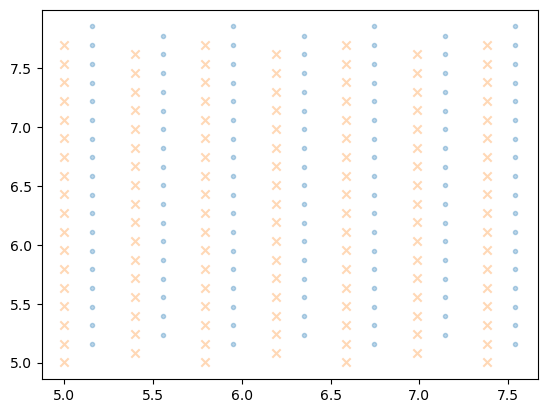

In [13]:
plt.scatter(X.numpy().flatten()[::10], Y.numpy().flatten()[::10], marker='.', alpha=.3)
plt.scatter(X_test.flatten()[::10], Y_test.flatten()[::10], marker='x', alpha=.3)

In [14]:
H_test_reshape = H_test.reshape((H_test.shape[0]*H_test.shape[1]*H_test.shape[2], H_test.shape[3]))
test_res = pinn1.net(H_test_reshape)

In [14]:
X_test.shape

(35, 35)

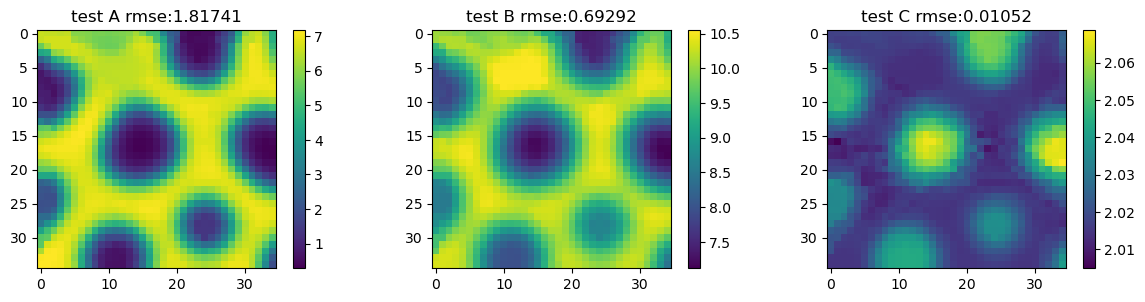

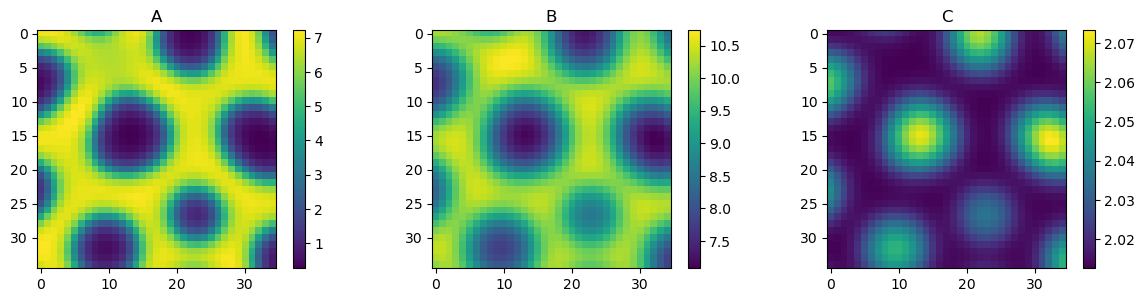

In [15]:
A_test = test_res[:,0].numpy().reshape(X_test.shape)
B_test = test_res[:,1].numpy().reshape(X_test.shape)
C_test = test_res[:,2].numpy().reshape(X_test.shape)
def rmse(arr1, arr2):
        return np.sqrt(np.mean((arr1-arr2)**2))
    
rmse1 = rmse(A_test, c[0,:, : , -1])
rmse2 = rmse(B_test, c[1,:, : , -1])
rmse3 = rmse(C_test, c[2,:, : , -1])

plot_n_im([A_test, B_test, C_test], 
          [f"test A rmse:{rmse1:.5f}", f"test B rmse:{rmse2:.5f}", f"test C rmse:{rmse3:.5f}"],
          figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([to(res[-1, 0, :])[x_slice, y_slice], to(res[-1, 1, :])[x_slice, y_slice], to(res[-1, 2, :])[x_slice, y_slice]], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()


In [400]:
#pinn1.save(".","temp_pinn")

In [16]:
c_xx =  np.array([[second_order_derivatives((x_size,y_size), data[c, ..., t])[0]/dxdy 
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
c_xx = np.einsum("ctij -> cijt", c_xx)
c_yy = np.array([[second_order_derivatives((x_size,y_size), data[c, ..., t])[1]/dxdy 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_yy = np.einsum("ctij -> cijt", c_yy)

D_A = params["D_A"]
D_B = params["D_B"]

#c_t = np.stack([f_A, f_B, f_C, f_D, f_E, f_F])[:,:,:, np.newaxis]

In [16]:
x_size, block_x, x_slice, data.shape

(127, 35, slice(65, 100, 1), (3, 128, 128, 1))

# $-\frac{1}{\pi \sigma^4} \frac{1 - (x^2+ y^2)}{2\sigma^2} \exp(\frac{- (x^2+ y^2)}{2\sigma^2}) $

In [17]:
def LoG(sigma, x, y):
    laplace = -1/(np.pi*sigma**4)*(1-(x**2+y**2)/(2*sigma**2))*np.exp(-(x**2+y**2)/(2*sigma**2))
    return laplace

def LoG_discrete(sigma, n):
    l = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            l[i,j] = LoG(sigma, (i-(n-1)/2),(j-(n-1)/2))
    return l



In [18]:

@tf.function
def grads(pinn, H):
    def flatten(arr):
        return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))
    
    with tf.GradientTape(persistent=True) as tape:
        # remove the boundaries
        H = H[:, :, :, :]
        H = flatten(H)
        tape.watch(H)
        
        outputs = pinn.net(H)
        Ag = tf.squeeze(outputs[:, 0])
        Bg = tf.squeeze(outputs[:, 1])
        Cg = tf.squeeze(outputs[:, 2])
        

        grad_A = tape.gradient(Ag, H)
        A_x = grad_A[:, 0]
        A_y = grad_A[:, 1]
        A_t = grad_A[:, 2]

        grad_B = tape.gradient(Bg, H)
        B_x = grad_B[:, 0]
        B_y = grad_B[:, 1]
        B_t = grad_B[:, 2]


        grad_A_x = tape.gradient(A_x, H)
        A_xx = grad_A_x[:, 0]
        grad_A_y = tape.gradient(A_y, H)
        A_yy = grad_A_y[:, 1]
        grad_B_x = tape.gradient(B_x, H)
        B_xx = grad_B_x[:, 0]
        grad_B_y = tape.gradient(B_y, H)
        B_yy = grad_B_y[:, 1]
        
        
    return (tf.squeeze(Ag), tf.squeeze(A_xx), tf.squeeze(A_yy), tf.squeeze(A_t),
            tf.squeeze(Bg), tf.squeeze(B_xx), tf.squeeze(B_yy), tf.squeeze(B_t),
            tf.squeeze(Cg)
           )                               



def plot_state(pinn, H,sigma = 1.4, kernel_size=4,centre=40,block_x=block_x, block_y=block_y):
    def to(arr):
        return arr.numpy().reshape(block_x, block_y)

    (A, A_xx, A_yy, A_t,
     B, B_xx, B_yy, B_t,
     C, 
    ) = grads(pinn, H)
    A = to(A)
    B = to(B)
    C = to(C)
    def rmse(arr1, arr2):
        return np.sqrt(np.mean((arr1-arr2)**2))
    #####################################################
    rmse1 = rmse(A, c[0,:, : , -1])    
    amp = np.max(c[0,:, : , -1]) - np.min(c[0,:, : , -1])
    plot_n_im([A, c[0,:, : , -1]], 
      [f"A rmse:{rmse1:.5f} \n relative rmse:{100*rmse1/amp:.2f}%", "Actual A"],          
      figsize=(12, 3)); plt.tight_layout()
    
    rmse2 = rmse(B, c[1,:, : , -1])
    amp = np.max(c[1,:, : , -1]) - np.min(c[1,:, : , -1])
    plot_n_im([B, c[1,:, :  , -1]], 
      [f"B rmse:{rmse2:.5f} \n relative rmse:{100*rmse2/amp:.2f}%", "Actual B"],          
      figsize=(12, 3)); plt.tight_layout()
    rmse3 = rmse(C, c[2,:, : , -1])
    amp = np.max(c[2,:, : , -1]) - np.min(c[2,:, : , -1])
    plot_n_im([C, c[2,:, : , -1]], 
      [f"C rmse:{rmse3:.5f} \n relative rmse:{100*rmse3/amp:.2f}%", "Actual C"],          
      figsize=(6, 3)); plt.tight_layout()
    ########################################################
    actual_A_der = ( c_xx[0,x_slice, y_slice  , -1] + c_yy[0,x_slice, y_slice  , -1])# - to(u_t2)[-1, ...]
    actual_B_der = ( c_xx[1,x_slice, y_slice  , -1] + c_yy[1,x_slice, y_slice  , -1])# - to(v_t2)[-1, ...]
    ######################################################## 
    
    data_out = np.stack([A, B, C])[..., np.newaxis]
    #kernel = LoG_discrete(sigma, kernel_size)#
    kernel = np.round(LoG_discrete(sigma, kernel_size)*(-centre/LoG(sigma,0,0))) 
    #print(kernel)
    c_kernel_der = np.array([[ndimage.convolve(data_out[c, ..., t], kernel)/dxdy 
                         for t in range(data_out.shape[3])]
                         for c in range(data_out.shape[0])
                        ])
    c_kernel_der = np.einsum("ctij -> cijt", c_kernel_der)*dxdy 
    
    # remove the boundary
    c_kernel_der = c_kernel_der[:, 1:-1, 1:-1, :]
    A_kernel_der = c_kernel_der[0, :, : ,-1]
    B_kernel_der = c_kernel_der[1, :, : ,-1]
    
    a_A_der_temp = actual_A_der[1:-1,1:-1]
    a_B_der_temp = actual_B_der[1:-1,1:-1]
    rmse1 = rmse(A_kernel_der,  a_A_der_temp)
    amp1 = np.max(a_A_der_temp) - np.min(a_A_der_temp)
    rmse2 = rmse(B_kernel_der,  a_B_der_temp)
    amp2 = np.max(a_B_der_temp) - np.min(a_B_der_temp)
    plot_n_im([A_kernel_der,  a_A_der_temp],
              [f"RHS A kernel rmse:{rmse1:.5f} \n relative rmse:{100*rmse1/amp1:.2f}%", 
               "Actual RHS A"],          
              figsize=(12, 3)); plt.tight_layout()
    plot_n_im([B_kernel_der,  a_B_der_temp],
              [f"RHS B  kernel rmse:{rmse2:.5f} \n relative rmse:{100*rmse2/amp2:.2f}%",
               "Actual RHS B"],          
              figsize=(12, 3)); plt.tight_layout()

    
    ########################################################    
    c_xx_out =  np.array([[second_order_derivatives((block_x, block_y), data_out[c, ..., t])[0]/dxdy 
                        for t in range(data_out.shape[3])]
                        for c in range(data_out.shape[0])
                       ])
    c_xx_out = np.einsum("ctij -> cijt", c_xx_out)
    c_yy_out = np.array([[second_order_derivatives((block_x, block_y), data_out[c, ..., t])[1]/dxdy 
                        for t in range(data_out.shape[3])]
                        for c in range(data_out.shape[0])
                       ])
    c_yy_out = np.einsum("ctij -> cijt", c_yy_out)
    # remove the boundary
    c_xx_out = c_xx_out[:, 1:-1, 1:-1, :]
    c_yy_out = c_yy_out[:, 1:-1, 1:-1, :]
        

    
    A_diff_der = ( c_xx_out[0,:, :  , -1] + c_yy_out[0,:, :  , -1])
    B_diff_der = ( c_xx_out[1,:, :  , -1] + c_yy_out[1,:, :  , -1])

    c_xx_temp = c_xx[0,x_slice, y_slice , -1][1:-1, 1:-1]
    c_yy_temp = c_yy[0,x_slice, y_slice , -1][1:-1, 1:-1]
    rmse1 = rmse(c_xx_out[0,:, : , -1], c_xx_temp)
    amp1 = np.max(c_xx_temp) - np.min(c_xx_temp)
    rmse2 = rmse(c_yy_out[0,:, :  , -1], c_yy_temp)
    amp2 = np.max(c_yy_temp) - np.min(c_yy_temp)
    plot_n_im([c_xx_out[0,:, : , -1], c_xx_temp,
               c_yy_out[0,:, :  , -1], c_yy_temp], 
              [f"A_xx diff rmse:{rmse1:.5f} \n relative rmse:{100*rmse1/amp1:.2f}%", 
               "Actual A_xx", 
               f"A_yy diff rmse:{rmse2:.5f} \n relative rmse:{100*rmse2/amp2:.2f}%", 
               "Actual A_yy"],          
              figsize=(12, 3)); plt.tight_layout()

    rmse1 = rmse(c_xx_out[1,:, :  , -1], c_xx[1,x_slice, y_slice  , -1][1:-1, 1:-1])
    rmse2 = rmse(c_yy_out[1,:, :  , -1], c_yy[1,x_slice, y_slice  , -1][1:-1, 1:-1])
    plot_n_im([c_xx_out[1,:, :  , -1], c_xx[1,x_slice, y_slice  , -1][1:-1, 1:-1], 
               c_yy_out[1,:, :  , -1], c_yy[1,x_slice, y_slice  , -1][1:-1, 1:-1]],
              [f"B_xx diff rmse:{rmse1:.5f} \n relative rmse:{100*rmse1/amp1:.2f}%",
               "Actual B_xx", 
               f"B_yy diff rmse:{rmse2:.5f} \n relative rmse:{100*rmse2/amp2:.2f}%", 
               "Actual B_yy"],          
              figsize=(12, 3)); plt.tight_layout()

    a_A_der_temp = actual_A_der[1:-1,1:-1]
    a_B_der_temp = actual_B_der[1:-1,1:-1]
    rmse1 = rmse(A_diff_der,  a_A_der_temp)
    amp1 = np.max(a_A_der_temp) - np.min(a_A_der_temp)
    rmse2 = rmse(B_diff_der,  a_B_der_temp)
    amp2 = np.max(a_B_der_temp) - np.min(a_B_der_temp)
    plot_n_im([A_diff_der,  a_A_der_temp],
              [f"RHS A diff rmse:{rmse1:.5f} \n relative rmse:{100*rmse1/amp1:.2f}%", 
               "Actual RHS A"],          
              figsize=(12, 3)); plt.tight_layout()
    plot_n_im([B_diff_der,  a_B_der_temp],
              [f"RHS B  diff rmse:{rmse2:.5f} \n relative rmse:{100*rmse2/amp2:.2f}%",
               "Actual RHS B"],          
              figsize=(12, 3)); plt.tight_layout()
    ############################################################
    A_xx = to(A_xx)
    A_yy = to(A_yy)
    B_xx = to(B_xx)
    B_yy = to(B_yy)
    
    A_der = A_xx + A_yy
    B_der = B_xx + B_yy

    rmse1 = rmse(A_xx, c_xx[0,x_slice, y_slice , -1])
    rmse2 = rmse(A_yy, c_yy[0,x_slice, y_slice  , -1])
    plot_n_im([A_xx, c_xx[0,x_slice, y_slice , -1],
               A_yy, c_yy[0,x_slice, y_slice  , -1]], 
      [f"A_xx rmse:{rmse1:.5f}", "Actual A_xx", f"A_yy rmse:{rmse2:.5f}", "Actual A_yy"],          
      figsize=(12, 3)); plt.tight_layout()
    
    
    rmse1 = rmse(B_xx, c_xx[1,x_slice, y_slice , -1])
    rmse2 = rmse(B_yy, c_yy[1,x_slice, y_slice  , -1])
    plot_n_im([B_xx, c_xx[1,x_slice, y_slice  , -1], 
               B_yy, c_yy[1,x_slice, y_slice  , -1]],
              [f"B_xx rmse:{rmse1:.5f}", "Actual B_xx", f"B_yy rmse:{rmse2:.5f}", "Actual B_yy"],          
              figsize=(12, 3)); plt.tight_layout()
    
    rmse1 = rmse(A_der,  actual_A_der)
    rmse2 = rmse(B_der,  actual_B_der)
    plot_n_im([A_der[1:-1,1:-1],  actual_A_der[1:-1,1:-1]],
              [f"RHS A rmse:{rmse1:.5f}", "Actual RHS A"],          
              figsize=(12, 3)); plt.tight_layout()
    plot_n_im([B_der[1:-1,1:-1],  actual_B_der[1:-1,1:-1]],
              [f"RHS B rmse:{rmse2:.5f}", "Actual RHS B"],          
              figsize=(12, 3)); plt.tight_layout()   

    
    plt.show()
    

def plot_state2(pinn, H,sigma = 1.4, kernel_size=4,centre=40,block_x=block_x, block_y=block_y):
    def to(arr):
        return arr.numpy().reshape(block_x, block_y)

    (A, A_xx, A_yy, A_t,
     B, B_xx, B_yy, B_t,
     C, 
    ) = grads(pinn, H)
    A = to(A)
    B = to(B)
    C = to(C)
    def rmse(arr1, arr2):
        return np.sqrt(np.mean((arr1-arr2)**2))
    #####################################################
    rmse1 = rmse(A, c[0,:, : , -1])    
    amp = np.max(c[0,:, : , -1]) - np.min(c[0,:, : , -1])
    plot_n_im([A, c[0,:, : , -1]], 
      [f"A rmse:{rmse1:.5f} \n relative rmse:{100*rmse1/amp:.2f}%", "Actual A"],          
      figsize=(12, 3)); plt.tight_layout()
    
    rmse2 = rmse(B, c[1,:, : , -1])
    amp = np.max(c[1,:, : , -1]) - np.min(c[1,:, : , -1])
    plot_n_im([B, c[1,:, :  , -1]], 
      [f"B rmse:{rmse2:.5f} \n relative rmse:{100*rmse2/amp:.2f}%", "Actual B"],          
      figsize=(12, 3)); plt.tight_layout()
    rmse3 = rmse(C, c[2,:, : , -1])
    amp = np.max(c[2,:, : , -1]) - np.min(c[2,:, : , -1])
    plot_n_im([C, c[2,:, : , -1]], 
      [f"C rmse:{rmse3:.5f} \n relative rmse:{100*rmse3/amp:.2f}%", "Actual C"],          
      figsize=(6, 3)); plt.tight_layout()
    ########################################################
    actual_A_der = ( c_xx[0,x_slice, y_slice  , -1] + c_yy[0,x_slice, y_slice  , -1])# - to(u_t2)[-1, ...]
    actual_B_der = ( c_xx[1,x_slice, y_slice  , -1] + c_yy[1,x_slice, y_slice  , -1])# - to(v_t2)[-1, ...]
    ######################################################## 
    
    data_out = np.stack([A, B, C])[..., np.newaxis]
    #kernel = LoG_discrete(sigma, kernel_size)#
    kernel = np.round(LoG_discrete(sigma, kernel_size)*(-centre/LoG(sigma,0,0))) 
    #kernel = LoG_discrete(sigma, kernel_size)*(-centre/LoG(sigma,0,0))
    #print(kernel)
    c_kernel_der = np.array([[ndimage.convolve(data_out[c, ..., t], kernel)/dxdy 
                         for t in range(data_out.shape[3])]
                         for c in range(data_out.shape[0])
                        ])
    c_kernel_der = np.einsum("ctij -> cijt", c_kernel_der)*dxdy 
    
    # remove the boundary
    c_kernel_der = c_kernel_der[:, 1:-1, 1:-1, :]
    A_kernel_der = c_kernel_der[0, :, : ,-1]
    B_kernel_der = c_kernel_der[1, :, : ,-1]
    
    a_A_der_temp = actual_A_der[1:-1,1:-1]
    a_B_der_temp = actual_B_der[1:-1,1:-1]
    rmse1 = rmse(A_kernel_der,  a_A_der_temp)
    amp1 = np.max(a_A_der_temp) - np.min(a_A_der_temp)
    rmse2 = rmse(B_kernel_der,  a_B_der_temp)
    amp2 = np.max(a_B_der_temp) - np.min(a_B_der_temp)
    plot_n_im([A_kernel_der,  a_A_der_temp],
              [f"RHS A kernel rmse:{rmse1:.5f} \n relative rmse:{100*rmse1/amp1:.2f}%", 
               "Actual RHS A"],          
              figsize=(12, 3)); plt.tight_layout()
    plot_n_im([B_kernel_der,  a_B_der_temp],
              [f"RHS B  kernel rmse:{rmse2:.5f} \n relative rmse:{100*rmse2/amp2:.2f}%",
               "Actual RHS B"],          
              figsize=(12, 3)); plt.tight_layout()  
    ########################################################       
    plt.show()

In [259]:
dxdy

0.0062988158226253465

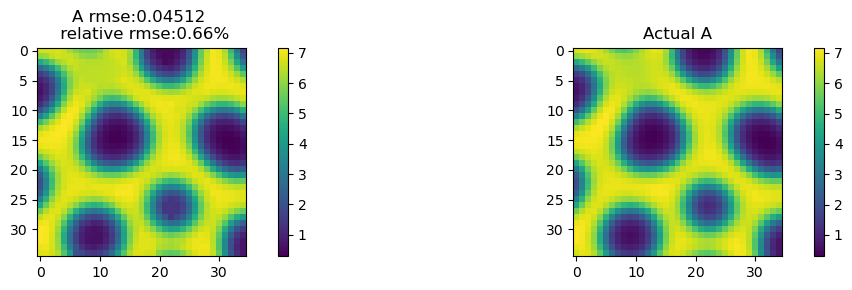

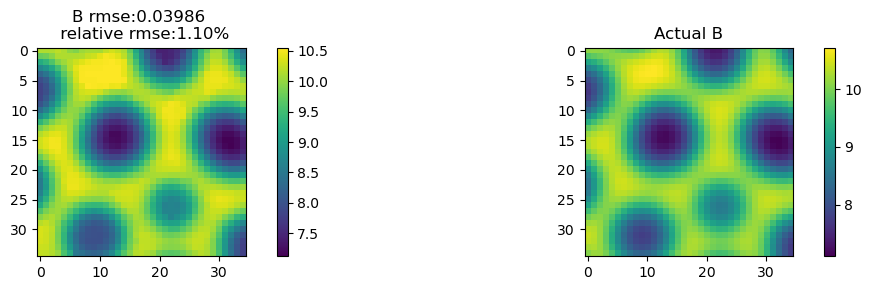

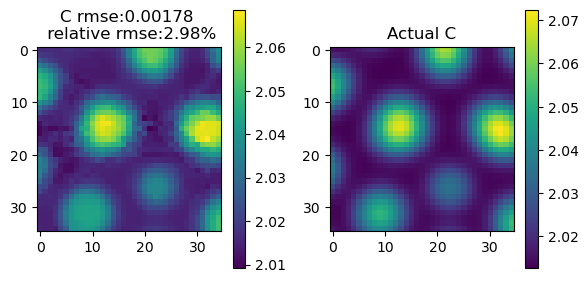

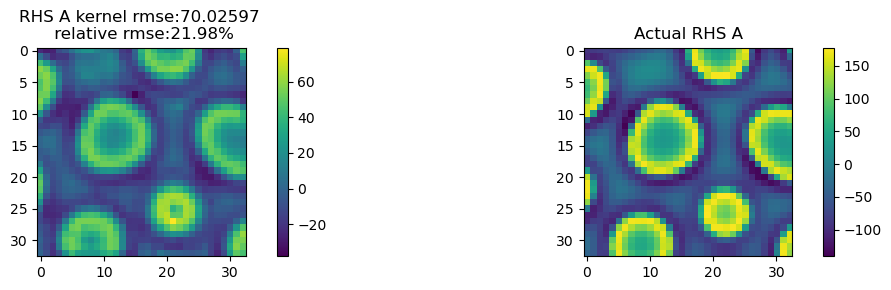

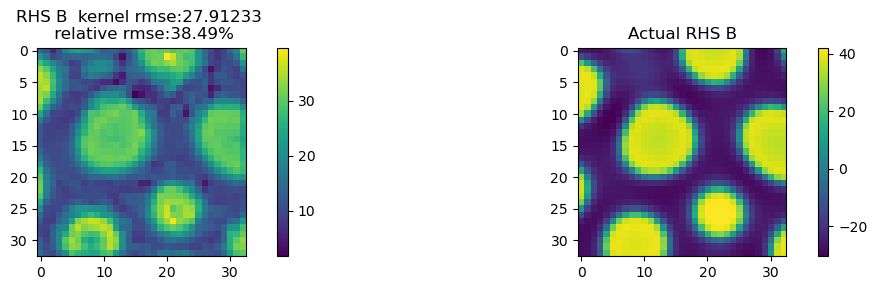

In [258]:
plot_state2(pinn1, H, sigma = .8, kernel_size=5,centre=50)

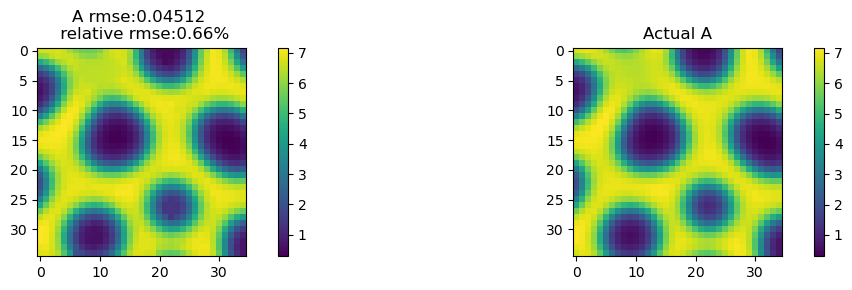

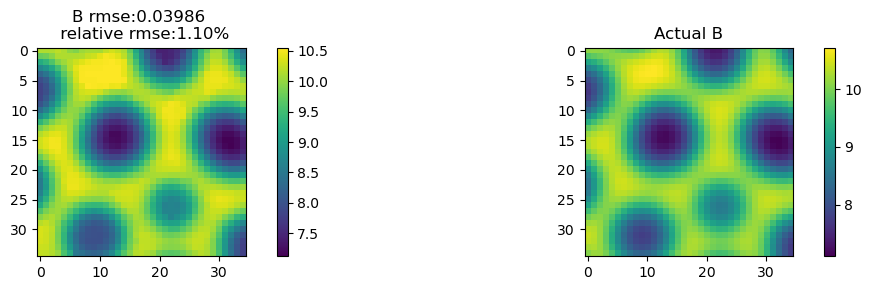

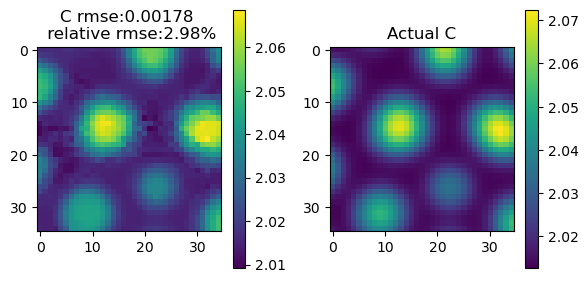

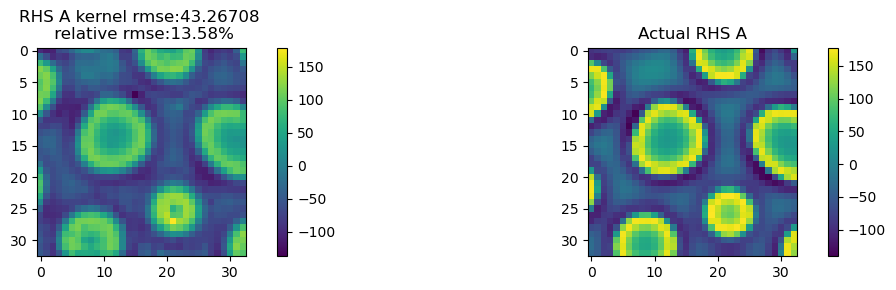

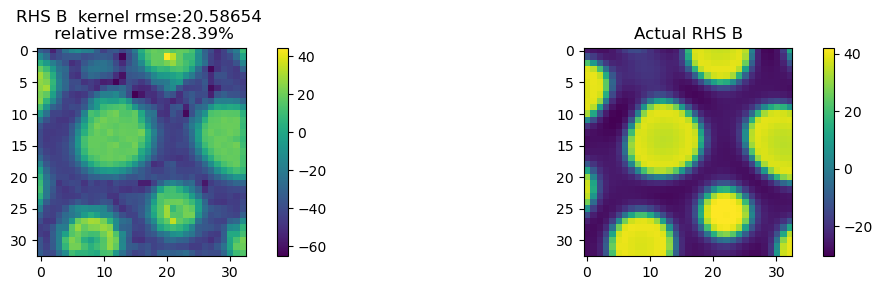

In [251]:
#plot_state2(pinn1, H, sigma = .75, kernel_size=5,centre=150)
plot_state2(pinn1, H, sigma = .75, kernel_size=5,centre=150)

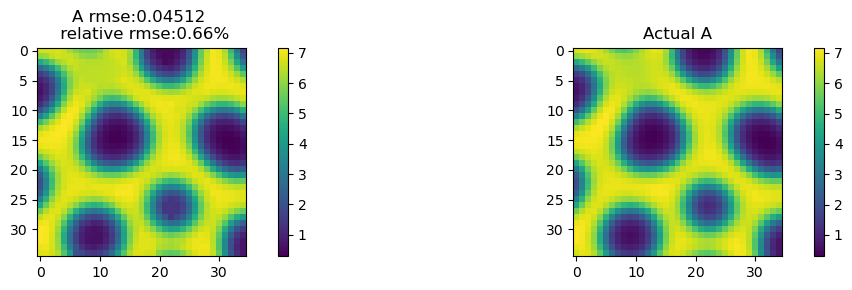

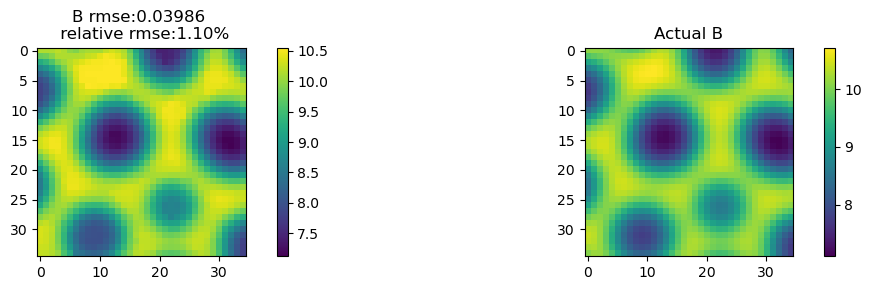

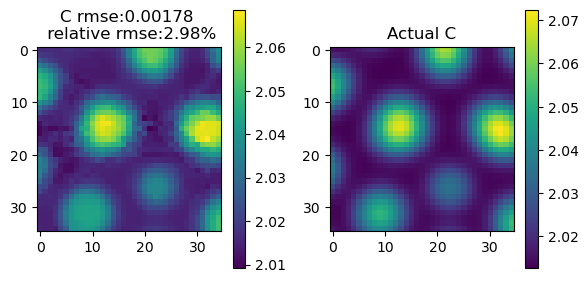

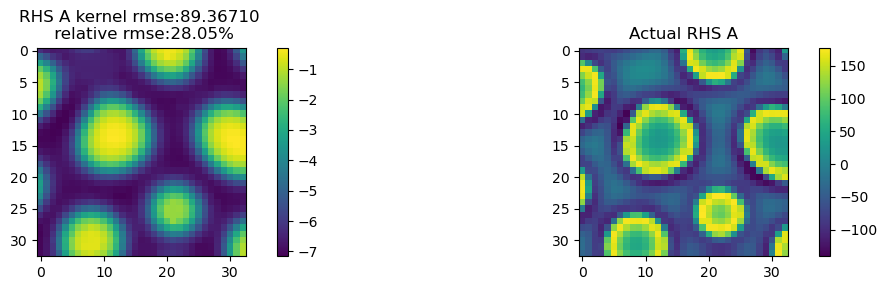

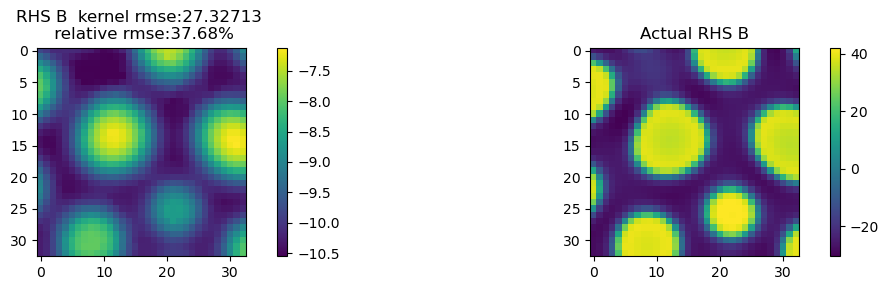

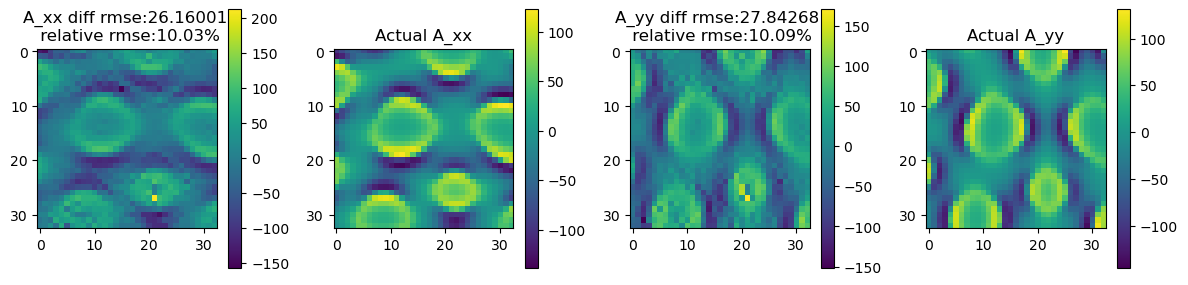

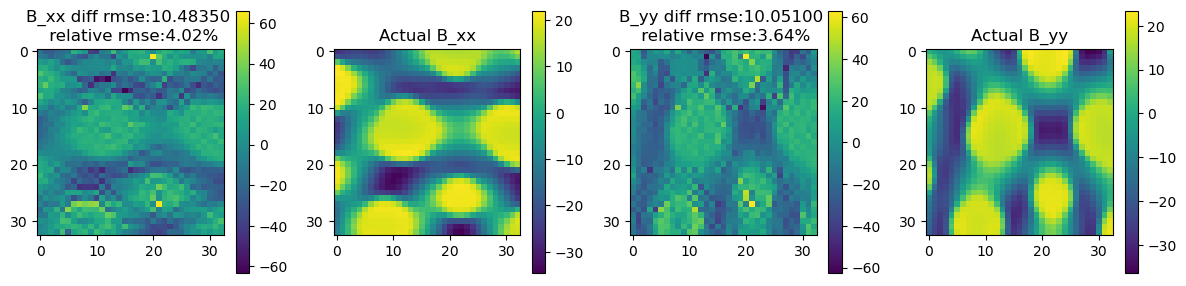

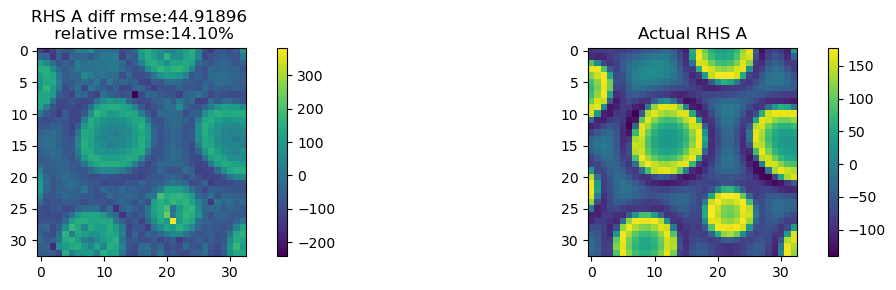

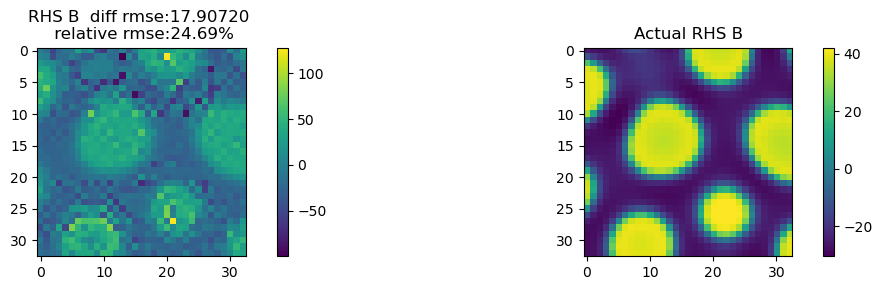

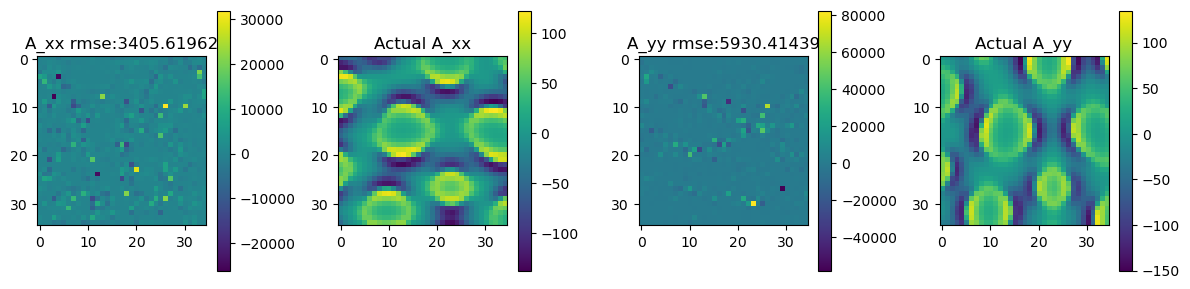

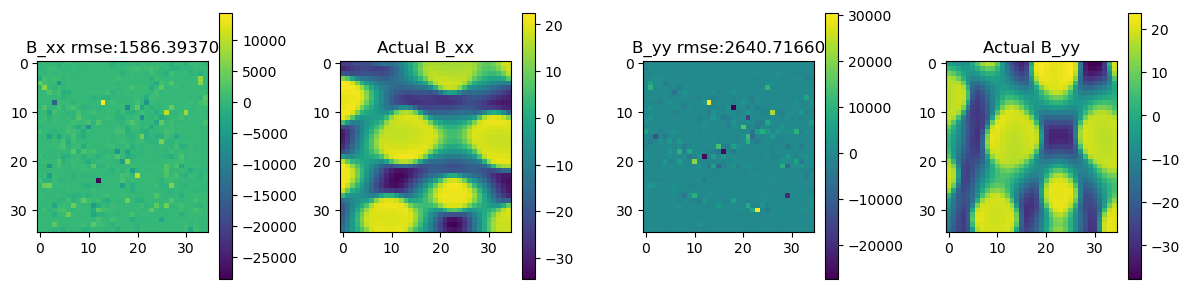

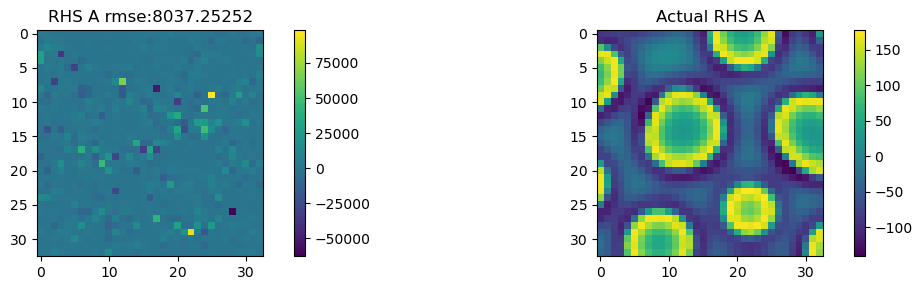

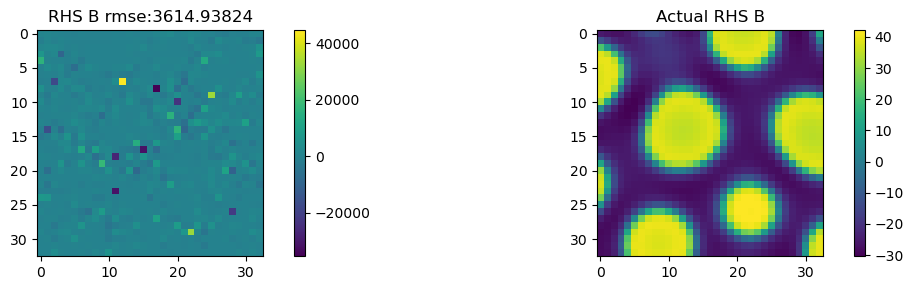

In [226]:
plot_state(pinn1, H, sigma = 1, kernel_size=9,centre=1)

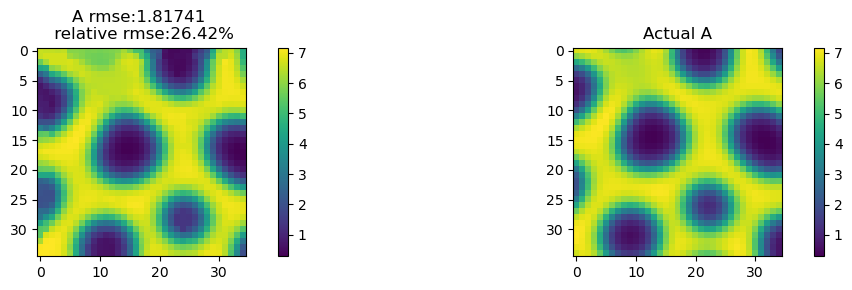

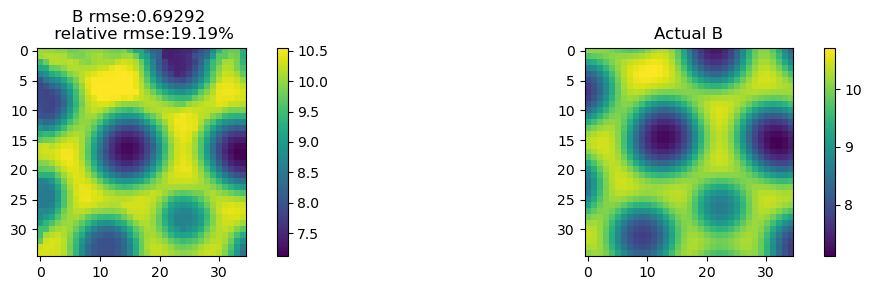

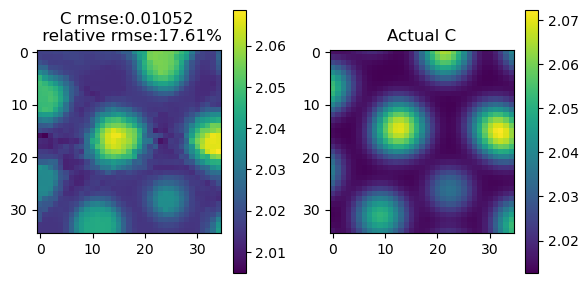

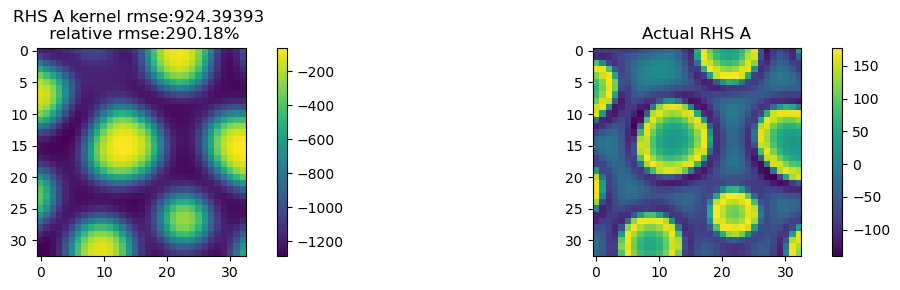

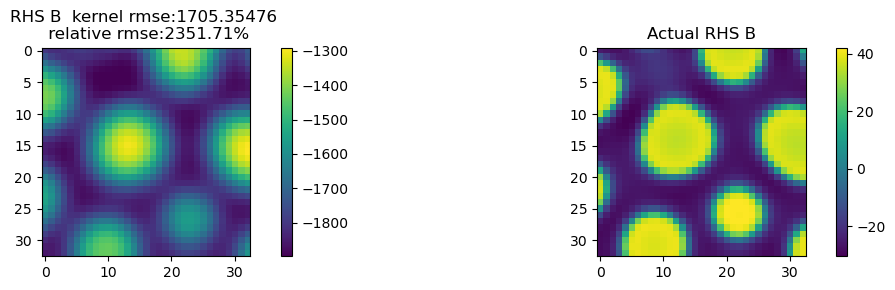

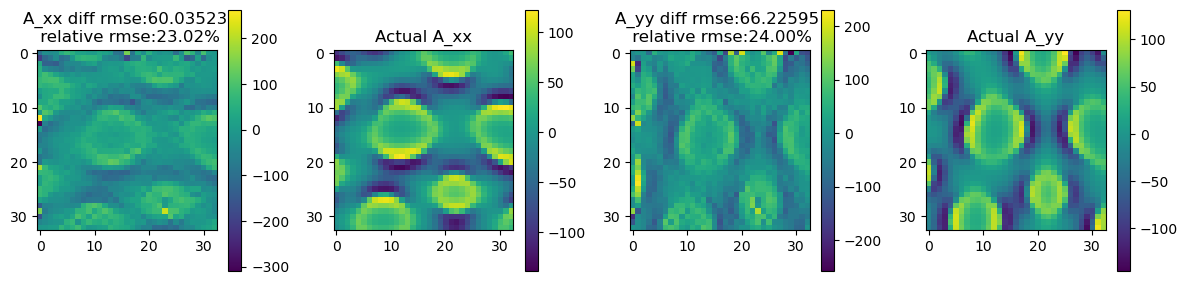

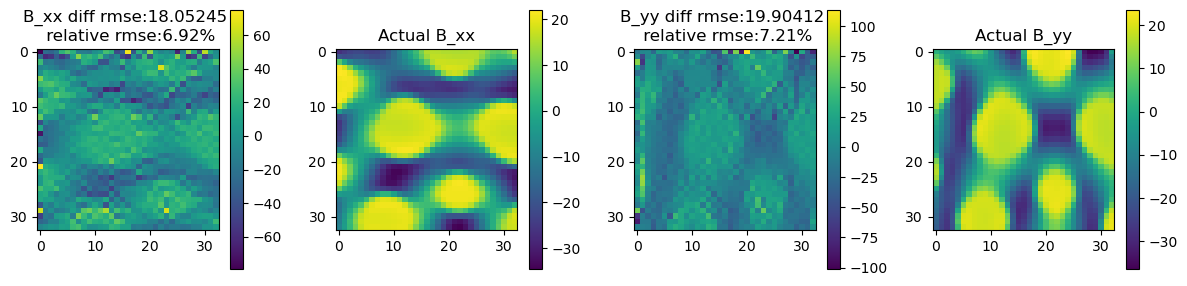

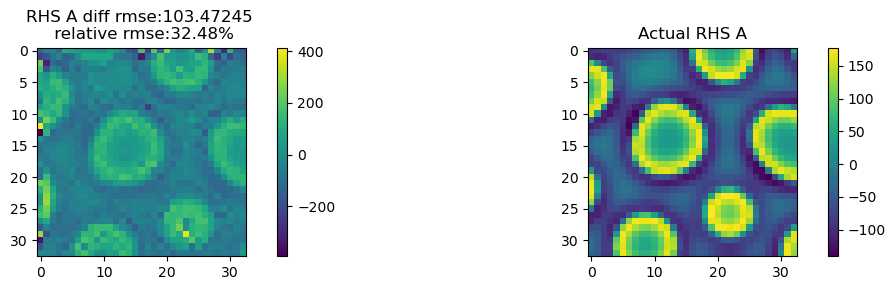

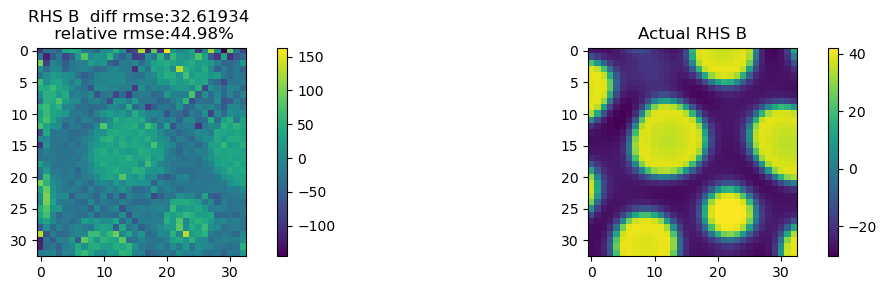

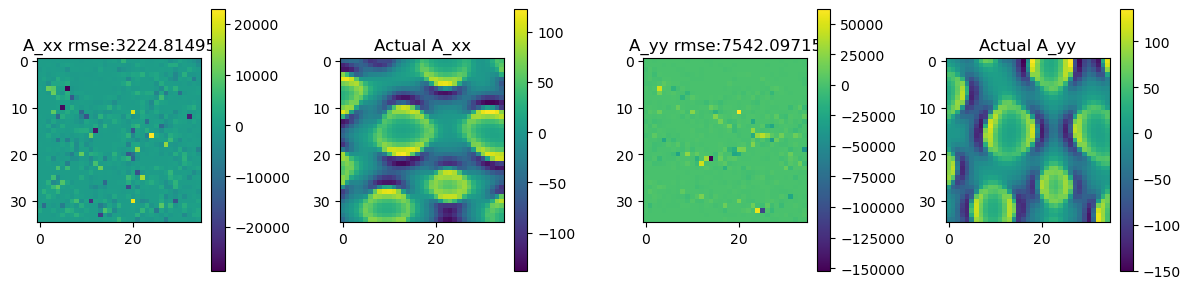

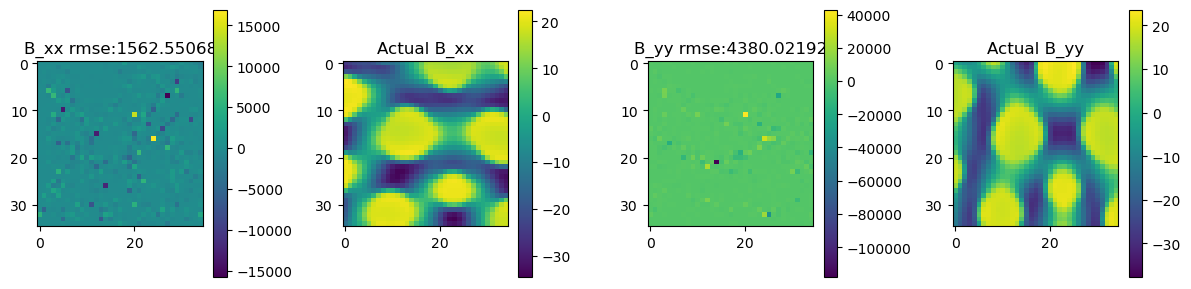

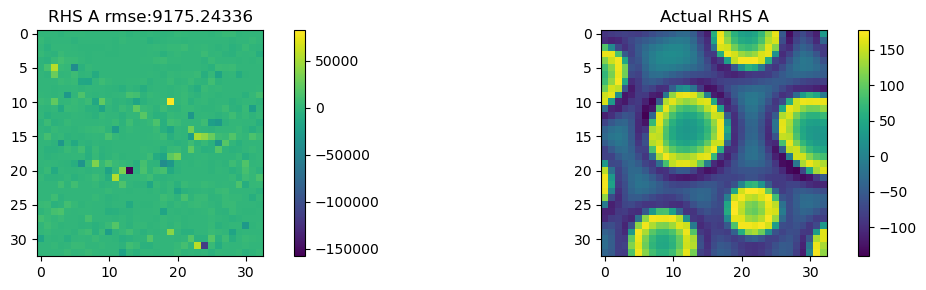

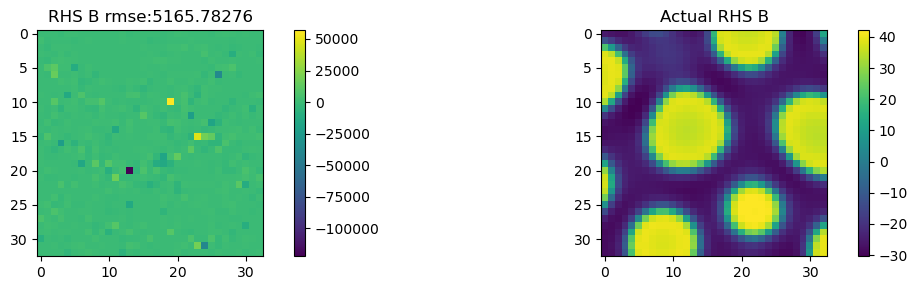

In [227]:
plot_state(pinn1, H_test)#,block_x=128,block_y=128)

In [228]:
def save_output(pinn, path):
    def to(arr):
        return arr.numpy().reshape(block_x, block_y)

    (A, A_xx, A_yy, A_t,
     B, B_xx, B_yy, B_t,
     C, 
    ) = grads(pinn, H)
    A = to(A)
    B = to(B)
    C = to(C)    
    
    data_out = np.stack([A, B, C])[..., np.newaxis]
    with open(f"{path}", "wb") as f:
        np.save(f, data_out)

In [229]:
save_output(pinn1, f"./index_{index}_noise_0.npy")

In [20]:
def to(arr):
    return arr.numpy().reshape(block_x, block_y)
(A, A_xx, A_yy, A_t,
     B, B_xx, B_yy, B_t,
     C, 
    ) = grads(pinn1, H)
A = to(A)
B = to(B)
C = to(C)  

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


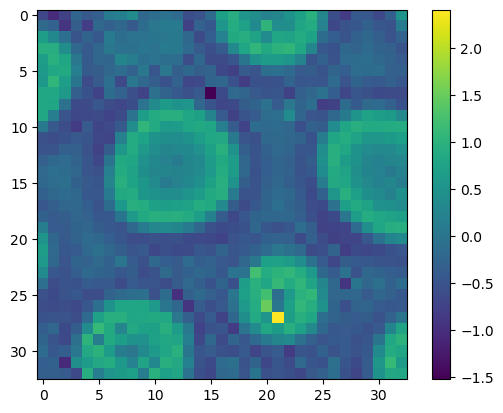

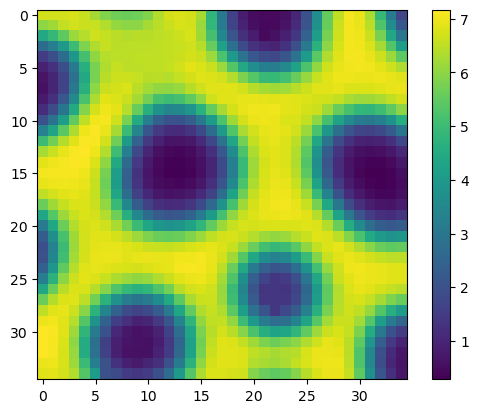

In [273]:
plt.imshow((A[2:, 1:-1]+A[:-2, 1:-1]-2*A[1:-1, 1:-1]
           +A[1:-1, 2:]+A[1:-1, :-2]-2*A[1:-1, 1:-1]));plt.colorbar();plt.show()
plt.imshow(A);plt.colorbar();plt.show()

In [19]:
class NN_2_res_pre(NN_2_res):
    def __init__(self, layers, lb, ub,pre_pinn, dtype=tf.float32, res_len=2,  **kwargs):
        """A dense Neural Net that is specified by layers argument.

        layers: input, dense layers and outputs dimensions
        lb    : An array of minimums of inputs (lower bounds)
        ub    : An array of maximums of inputs (upper bounds)
        """
        #super().__init__(dtype, **kwargs)
        self.dtype = dtype
        self.__version__ = 0.1
        self.layers = layers
        self.num_layers = len(self.layers)
        self.lb = lb
        self.ub = ub
        self.res_len = res_len
        self.pre_Ws = [w.numpy() for w in pre_pinn.weights]
        self.pre_as = [a.numpy() for a in pre_pinn.scales]
        self.pre_bs = [b.numpy() for b in pre_pinn.biases]
        self.pre_lb = pre_pinn.lb
        self.pre_ub = pre_pinn.ub
        self.build()
        
    def create_1_unit_layer(self, layers):
        weights = []
        scales = []
        biases = []
        for i in range(0, self.num_layers - 1):
            W = self.xavier_init(size=[layers[i], layers[i + 1]])            
            a = tf.Variable(tf.ones([1, self.layers[i + 1]], dtype=self.dtype), dtype=self.dtype)
            b = tf.Variable(tf.zeros([1, layers[i + 1]], dtype=self.dtype), dtype=self.dtype)
            weights.append(W)
            scales.append(a)
            biases.append(b)
        return weights, scales, biases 
    
    def create_pre_layer(self):
        weights = []
        scales = []
        biases = []
        for pre_W, pre_a, pre_b in zip(self.pre_Ws, self.pre_as, self.pre_bs):
            W = tf.Variable(pre_W, trainable=False, dtype=self.dtype)
            a = tf.Variable(pre_a, trainable=False, dtype=self.dtype)
            b = tf.Variable(pre_b, trainable=False, dtype=self.dtype)
            weights.append(W)
            scales.append(a)
            biases.append(b)            
        return weights, scales, biases  

    def net_1_layer(self, Ws, as_, bs, H):
        for W, a, b in zip(Ws, as_, bs):
            outputs = tf.matmul(H, W)
            outputs = a * outputs + b
            H = tf.tanh(outputs)
            
        return outputs
    
       
    def build(self):
        """Create the state of the layers (weights)"""
        self.Ws_layers = []
        self.as_layers = []
        self.bs_layers = []
        Ws, as_, bs = self.create_pre_layer()
        self.Ws_layers.append(Ws)
        self.as_layers.append(as_)
        self.bs_layers.append(bs)
        for i in range(self.res_len):
            Ws, as_, bs = self.create_1_unit_layer(self.layers)
            self.Ws_layers.append(Ws)
            self.as_layers.append(as_)
            self.bs_layers.append(bs)
    
    @tf.function
    def net(self, inputs):
        # Map the inputs to the range [-1, 1]
        H1 = 2.0 * (inputs - self.lb) / (self.ub - self.lb) - 1.0
        H1 = self.net_1_layer(self.Ws_layers[0], self.as_layers[0], self.bs_layers[0], H1)
        for i in range(1, self.res_len+1):
            H2 = tf.nn.tanh(H1)
            H3 = self.net_1_layer(self.Ws_layers[i], self.as_layers[i], self.bs_layers[i], H2)
            H1 += H3
        
#         H1 = tf.nn.tanh(H1)
#         H2 = self.net_1_layer(self.Ws_layers[-1], self.bs_layers[-1], H1)
#         return H2
        return H1


    def __call__(self, inputs):
        """Defines the computation from inputs to outputs

        Args:
           inputs: A tensor that has a shape [None, D1], where
                   D1 is the input dimensionality, specified in
                   the first element of layes.

        Return:
                A tensor of the dense layer output that has a shape
                [None, Dn], where Dn is the dimensionality of the last
                layer, specificed by the last elements of the layer
                arguemnt.
        """
        X = tf.cast(inputs, self.dtype)
        return self.net(X)

In [20]:
def create_pinn_2(pre_pinn, layers=[3, 512, 512, 3], res_len = 2,
                learning_rate=1e-2,                
                w1=1, w2=1, w3=1, w4=1, w5=1, w6=1,
                D_A_val=tf_param("D_A"), D_B_val=tf_param("D_B"),
                b_A_val=tf_param("b_A"),b_B_val=tf_param("b_B"),b_C_val=tf_param("b_C"),
                V_A_val=tf_param("V_A"),V_B_val=tf_param("V_B"),V_C_val=tf_param("V_C"),
                mu_A_val=tf_param("mu_A"),mu_B_val=tf_param("mu_B"),mu_C_val=tf_param("mu_C"),
                K_AA_val=tf_param("K_AA"),K_AB_val=tf_param("K_AB"),K_AC_val=tf_param("K_AC"),
                K_BA_val=tf_param("K_BA"),K_BC_val=tf_param("K_BC"),
                K_CB_val=tf_param("K_CB"),K_CC_val=tf_param("K_CC"),
                n_val=tf_param("n")): 
    # Since there is just one time step, the lower bound is zero and the upper bound is one
    lb = tf.constant([x_range[0], y_range[0], 0], dtype=tf.float32)
    ub =  tf.constant([x_range[-1], y_range[-1], t_star[0]], dtype=tf.float32)    
    pinn = tu.NN_Scaled(layers, lb, ub, tf.float32)
    #pinn = NN_2_res_pre(layers, lb, ub, pre_pinn, tf.float32, res_len)
    #optimizer=keras.optimizers.Adam(learning_rate=1e-2)   
    #optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate)
                    
    def create_tf_var(param, no_clip=False):
        print(f"{param.name}: {param.value}")
        if no_clip:
            return tf.Variable(param.value,
                               dtype=pinn.dtype,
                               name=param.name)
        else:
            return tf.Variable(param.value,
                               dtype=pinn.dtype,
                               name=param.name,
                               constraint=clip_by_value_zero_lb)
    
    D_A = create_tf_var(D_A_val)    
    D_B = create_tf_var(D_B_val)
    b_A = create_tf_var(b_A_val)#
    b_B = create_tf_var(b_B_val)#
    b_C = create_tf_var(b_C_val)#
    V_A = create_tf_var(V_A_val)
    V_B = create_tf_var(V_B_val)
    V_C = create_tf_var(V_C_val)
    mu_A = create_tf_var(mu_A_val)
    mu_B = create_tf_var(mu_B_val)
    mu_C = create_tf_var(mu_C_val)
    K_AA = create_tf_var(K_AA_val)
    K_AB = create_tf_var(K_AB_val)
    K_AC = create_tf_var(K_AC_val)
    K_BA = create_tf_var(K_BA_val)
    K_BC = create_tf_var(K_BC_val)
    K_CB = create_tf_var(K_CB_val)
    K_CC = create_tf_var(K_CC_val)
    n = create_tf_var(n_val)
    
    w1 = tf.Variable(w1,dtype=pinn.dtype,name="w1")
    w2 = tf.Variable(w2,dtype=pinn.dtype,name="w2")
    w3 = tf.Variable(w3,dtype=pinn.dtype,name="w3")
    w4 = tf.Variable(w4,dtype=pinn.dtype,name="w4")  
    w5 = tf.Variable(w3,dtype=pinn.dtype,name="w5")
    w6 = tf.Variable(w4,dtype=pinn.dtype,name="w6")  
                        
    def as_tuple(val, param):
        if val.is_constant:
            return ()
        else:
            return (param,)
    
    
    params_trainable =(
                      as_tuple(D_A_val, D_A)
                    + as_tuple(D_B_val, D_B)
                    + as_tuple(b_A_val, b_A)
                    + as_tuple(b_B_val, b_B)
                    + as_tuple(b_C_val, b_C)
                    + as_tuple(V_A_val, V_A)
                    + as_tuple(V_B_val, V_B)
                    + as_tuple(V_C_val, V_C)
                    + as_tuple(mu_A_val, mu_A)
                    + as_tuple(mu_B_val, mu_B)
                    + as_tuple(mu_C_val, mu_C)                    
                    + as_tuple(K_AA_val, K_AA)
                    + as_tuple(K_AB_val, K_AB)
                    + as_tuple(K_AC_val, K_AC)
                    + as_tuple(K_BA_val, K_BA)
                    + as_tuple(K_BC_val, K_BC)
                    + as_tuple(K_CB_val, K_CB)
                    + as_tuple(K_CC_val, K_CC)
                   )

    @tf.function
    def train_step_inverse(elements):
        def flatten(arr):
            return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))
        
        
        # Using VALID padding removes the boundaries
        #print(elements[1][..., 0:1].shape)
#         act_A_laplacian = pinn.derivative_fields(elements[1][..., 0:1], padding="VALID")
#         #print(act_A_laplacian.shape)
#         act_A_laplacian = flatten(act_A_laplacian)
#         #print(act_A_laplacian.shape)
#         act_B_laplacian = pinn.derivative_fields(elements[1][..., 1:2], padding="VALID") 
#         act_B_laplacian = flatten(act_B_laplacian)

#         act_A_rhs = tf.squeeze(D_A*act_A_laplacian/(dxdy))
#         act_B_rhs = tf.squeeze(D_B*act_B_laplacian/(dxdy))
        
        with tf.GradientTape(persistent=True) as tape: 
            H = elements[0]
            # remove the boundaries
            #H = H[:, 1:-1, 1:-1, :]               
            H = flatten(H)
            tape.watch(H)
            trainables = pinn.trainable_variables  + params_trainable 

            outputs = pinn.net(H)
            Ag = tf.squeeze(outputs[:, 0])
            Bg = tf.squeeze(outputs[:, 1])
            Cg = tf.squeeze(outputs[:, 2])
            
            grad_A = tape.gradient(Ag, H)
            A_x = grad_A[:, 0]
            A_y = grad_A[:, 1]

            grad_B = tape.gradient(Bg, H)
            B_x = grad_B[:, 0]
            B_y = grad_B[:, 1]


            grad_A_x = tape.gradient(A_x, H)
            A_xx = grad_A_x[:, 0]
            grad_A_y = tape.gradient(A_y, H)
            A_yy = grad_A_y[:, 1]
            grad_B_x = tape.gradient(B_x, H)
            B_xx = grad_B_x[:, 0]
            grad_B_y = tape.gradient(B_y, H)
            B_yy = grad_B_y[:, 1]
            
            H2 = elements[1]
            # remove the boundaries
            #H2 = H2[:, 1:-1, 1:-1, :]
            H2 = flatten(H2)
            A = tf.squeeze(H2[:, 0])
            B = tf.squeeze(H2[:, 1])
            C = tf.squeeze(H2[:, 2])                
            
            l2_A = tf.reduce_mean((A - Ag)**2)
            l2_B = tf.reduce_mean((B - Bg)**2)
            l2_C = tf.reduce_mean((C - Cg)**2)            

           
            def act(x, km, n=2):
                return 1 / (1 + (km / (x + 1e-20)) ** (n))

            def inh(x, km, n=2):
                return 1 / (1 + (x / (km + 1e-20)) ** (n))

            A_rhs = D_A * (A_xx + A_yy)# - u_t
            B_rhs = D_B * (B_xx + B_yy)# - v_t
            

            f_A =  b_A + V_A*act(A, K_AA, n)*inh(B, K_BA, n) - mu_A * A + A_rhs
            f_B =  b_B + V_B*act(A, K_AB, n)*inh(C, K_CB, n) - mu_B * B + B_rhs
            f_C =  b_C + V_C*inh(A, K_AC, n)*inh(B, K_BC, n)*act(C, K_CC, n) - mu_C * C
            
            l2_res_A = tf.reduce_mean(f_A**2)
            l2_res_B = tf.reduce_mean(f_B**2)
            l2_res_C = tf.reduce_mean(f_C**2)        
            

#             l2_res_A_rhs = tf.reduce_sum((A_rhs-act_A_rhs)**2)
#             l2_res_B_rhs = tf.reduce_sum((B_rhs-act_B_rhs)**2)


            l2 = (w1*l2_A + w2*l2_B + 
                  w3*l2_C +
                  w4*l2_res_A + w5*l2_res_B + 
                  w6*l2_res_C 
                  #+w4*l2_res_A_rhs + w5*l2_res_B_rhs
                 )
        
        grads = tape.gradient(l2, trainables)
        #print(tf.reduce_mean([tf.reduce_mean(g) for g in grads]))
        optimizer.apply_gradients(zip(grads, trainables))
        return (l2_A, l2_B, l2_C, 
          l2_res_A, l2_res_B, 
                l2_res_C,  
                #l2_res_A_rhs, l2_res_B_rhs
        )
    
    names = ['l2_A', 'l2_B', 'l2_C', 
             'l2_res_A', 'l2_res_B', 'l2_res_C', 
            #'l2_res_A_rhs', 'l2_res_B_rhs'
            ]
    def print_callback(printer, losses, epoch):

        printer(f"at epoch {epoch:d}, total loss: {np.sum(losses)}, rmse loss: {np.sqrt(np.sum(losses))}")
        printer(", ".join([f"{n}: {v:.8f}" for n,v in zip(names, losses)]))         
        printer(", ".join([f"{par.name}: {par.numpy()}" for par in params_trainable]))
    
    return (pinn, optimizer, train_step_inverse,params_trainable, names, print_callback,
            w1, w2, w3, w4, w5, w6)

In [38]:
(pinn2, optimizer2, train_step_inverse2,params_trainable,names, print_callback2,
w21, w22, w23, w24, w25, w26) = create_pinn_2(pinn1,layers=[3, 1024,1024, 3],learning_rate=1e-2,
                               res_len=2, w1=1, w2=1, w3=1, w4=1, w5=1, w6=1,
b_A_val=tf_param("b_A", 1, False),b_B_val=tf_param("b_B", 1, False),
                                  b_C_val=tf_param("b_C", 1, False),
V_A_val=tf_param("V_A", 1, False),V_B_val=tf_param("V_B", 1, False),
                                  V_C_val=tf_param("V_C", 1, False),
K_AA_val=tf_param("K_AA", 1, False),K_AB_val=tf_param("K_AB", 1, False),
K_AC_val=tf_param("K_AC", 1, False), K_BA_val=tf_param("K_BA", 1, False),
K_BC_val=tf_param("K_BC", 1, False), K_CB_val=tf_param("K_CB", 1, False),
K_CC_val=tf_param("K_CC", 1, False),  )

D_A: 0.01
D_B: 1.0
b_A: 1
b_B: 1
b_C: 1
V_A: 1
V_B: 1
V_C: 1
mu_A: 1.0
mu_B: 5.0
mu_C: 0.5
K_AA: 1
K_AB: 1
K_AC: 1
K_BA: 1
K_BC: 1
K_CB: 1
K_CC: 1
n: 4.0


In [22]:
def to(arr):
    return arr.numpy().reshape(block_x, block_y)
(A, A_xx, A_yy, A_t,
     B, B_xx, B_yy, B_t,
     C, 
    ) = grads(pinn1, H)
A = to(A)
B = to(B)
C = to(C)
data_out = np.stack([A, B, C])[..., np.newaxis]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [23]:
c2 = data_out.copy()

In [24]:
c2.shape

(3, 35, 35, 1)

In [25]:
def gen_series2():    
    
    for i in range(H.shape[0]):        
        yield H[i, ...], np.einsum( "cxy -> xyc", c2[..., i]) 
        
ds2 = tf.data.Dataset.from_generator(gen_series2,
                                    output_types=(tf.float32, tf.float32), 
                                    output_shapes=((H.shape[1],H.shape[2], H.shape[3]),
                                                   (c.shape[1],c.shape[2], c.shape[0])))

In [26]:
from scipy.optimize import minimize

def alienor_components2(epsilon, l1, bounds):
    """
    
    Args:
          epsilon (float): The accuracy of the estimates.
          l1 (float): Lipschitz constant
          bounds (list of tuples):
          bounds like [a_i, b_i], for each variables separatly.
          
          
    """
    n = len(bounds) 
    assert n >= 2, "The method expects two or more vairbales."
    assert np.all([len(item) == 2 
                   for item in bounds]), "bounds must be tuple of (a_i,b_i)"
    
    alpha = epsilon/(2*l1*np.sqrt(n-1))
    alphas = np.ones(n)
    
    def get_h_i(a,b,alpha):
        def h_i(t):
            return (a-b)*np.cos(alpha*t)/2 + (a+b)/2
        return h_i
    a,b = bounds[0]
    h_i = get_h_i(a,b,1)
    h_list = [h_i]
    for i in range(1, n):
        # [a_i, b_i]
        a,b = bounds[i]
        # alphas[i-1] (alpha/pi) / (|b_i| + |a_i|)
        alphas[i] = alpha*alphas[i-1]/(np.pi*(np.abs(b)+np.abs(a)))
        # h_i = (a_i - b_i)cos(alpha_i theta)/2 +  (a_i + b_i)/2         
        h_i = h_i = get_h_i(a,b,alphas[i])#
        h_list.append(h_i)        
        
        
    # l2 or Lipschitz constant of the aliemor h functions
    l2 = np.linalg.norm([(np.abs(d[1])+np.abs(d[0]))**2 * a**2 for d,a in zip(bounds,alphas) ])/2
    #
    theta_max = np.pi/alphas[-1]    
    return alpha, alphas, l2, h_list, theta_max

def minim_2(epsilon, l1, bounds, func, maxiter=10000):
    alpha, alphas, l2, h_list, theta_max = alienor_components2(epsilon, l1, bounds)
    k = 1
    L = l1 * l2
    theta = epsilon / L    
    theta_epsilon = theta
    
    f = lambda t: func(*[ h(t) for h in h_list])
    f_epsilon = f_theta = f(theta_epsilon)
    
    while k < maxiter:
        if theta > np.pi/alphas[-1]:            
            return k, theta,theta_epsilon, f_epsilon, ""
        
        theta = theta + (epsilon + f_theta - f_epsilon)/ L        
        f_theta  =  f(theta)
        if f_theta < f_epsilon:
            f_epsilon = f_theta
            theta_epsilon = theta
        k += 1    
    return k, theta,theta_epsilon, f_epsilon, f"max iteration '{maxiter}' is reached"

In [27]:
bounds_A = [(0,30), (0,200), (0,30), (0,30)]
bounds_B = [(0,30), (0,200), (0,30), (0,30)]
bounds_C = [(0,30), (0,200), (0,30), (0,30), (0,30)]
epsilon = 1e-3
l1 = 1

alpha_A, alphas_A, l2_A, h_list2_A, theta_max2_A = alienor_components2(epsilon, l1, bounds_A)
alpha_B, alphas_B, l2_B, h_list2_B, theta_max2_B = alienor_components2(epsilon, l1, bounds_B)
alpha_C, alphas_C, l2_C, h_list2_C, theta_max2_C = alienor_components2(epsilon, l1, bounds_C)
L_A = l1*l2_A
L_B = l1*l2_B
L_C = l1*l2_C
print("delta theta A:", epsilon/L_A)
print("delta theta A:", L_A/epsilon)
print()
print("delta theta B:", epsilon/L_B)
print("delta theta B:", L_B/epsilon)
print()
print("delta theta C:", epsilon/L_C)
print("delta theta C:", L_C/epsilon)

batch_size = 10000
print("A epochs:", L_A/epsilon/batch_size)
print("B epochs:", L_B/epsilon/batch_size)
print("C epochs:", L_C/epsilon/batch_size)

thetas_A = np.linspace(0, theta_max2_A,  int(L_A/epsilon))
thetas_B = np.linspace(0, theta_max2_B,  int(L_B/epsilon))
thetas_C = np.linspace(0, theta_max2_C,  int(L_C/epsilon))

params_by_theta_A = np.stack([h_list2_A[0](thetas_A), h_list2_A[1](thetas_A),
                              h_list2_A[2](thetas_A), h_list2_A[3](thetas_A)]).T

params_by_theta_B = np.stack([h_list2_B[0](thetas_B), h_list2_B[1](thetas_B),
                              h_list2_B[2](thetas_B), h_list2_B[3](thetas_B)]).T

params_by_theta_C = np.stack([h_list2_C[0](thetas_C), h_list2_C[1](thetas_C),
                              h_list2_C[2](thetas_C), h_list2_C[3](thetas_C),
                              h_list2_C[4](thetas_C)]).T

theta_A_n = params_by_theta_A.shape[0]
theta_A_m = params_by_theta_A.shape[1]
theta_B_n = params_by_theta_B.shape[0]
theta_B_m = params_by_theta_B.shape[1]
theta_C_n = params_by_theta_C.shape[0]
theta_C_m = params_by_theta_C.shape[1]

D_A = params["D_A"]
D_B = params["D_B"]

def Create_f_A(A, B, C, n, mu_A, A_diffu=None):
    def act(x, km, n=4):
        return 1 / (1 + (km / (x + 1e-20)) ** (n))

    def inh(x, km, n=4):
        return 1 / (1 + (x / (km + 1e-20)) ** (n))
    A_flat = A.flatten()[np.newaxis, :]
    B_flat = B.flatten()[np.newaxis, :]    
    #A_diffu =  0.01* diffu_2D(A).flatten()[np.newaxis, :]
    if A_diffu is None:
        dxdy = (10*10)/((A.shape[0]-1)*(A.shape[1]-1))
        A_diffu = ((1.0/dxdy)*(diffusion((A.shape[0],A.shape[1]),A))).flatten()[np.newaxis, :]

    def L_2_f_a(args):
        (b_A, V_A,  K_AA, K_BA
        ) = (args[:, 0:1], args[:, 1:2], args[:, 2:3], args[:, 3:4])
        f1 = (b_A + V_A*act(A_flat, K_AA, n)*inh(B_flat, K_BA, n) - mu_A*A_flat 
              + D_A*A_diffu)
        f2 = (b_A/(D_A+1e-6) + V_A*act(A_flat, K_AA, n)*inh(B_flat, K_BA, n)/(D_A+1e-6) 
              - mu_A*A_flat/(D_A+1e-6) + A_diffu)

        return np.sum((f1**2 + f2**2 )/A_flat.size, axis=1)
    return L_2_f_a

def Create_f_A_1_D(A, B, C, n, mu_A, A_diffu=None):
    def act(x, km, n=4):
        return 1 / (1 + (km / (x + 1e-20)) ** (n))

    def inh(x, km, n=4):
        return 1 / (1 + (x / (km + 1e-20)) ** (n))
    A_flat = A.flatten()[np.newaxis, :]
    B_flat = B.flatten()[np.newaxis, :]    
    #A_diffu =  0.01* diffu_2D(A).flatten()[np.newaxis, :]
    if A_diffu is None:
        dxdy = (10*10)/((A.shape[0]-1)*(A.shape[1]-1))
        A_diffu = ((1.0/dxdy)*(diffusion((A.shape[0],A.shape[1]),A))).flatten()[np.newaxis, :]
    def L_2_f_a(args):        
        (b_A,V_A, K_AA, K_BA
        ) = (args[0], args[1], args[2], args[3])
        f1 = (b_A + V_A*act(A_flat, K_AA, n)*inh(B_flat, K_BA, n) - mu_A*A_flat 
              + D_A*A_diffu)
        f2 = (b_A/(D_A+1e-6) + V_A*act(A_flat, K_AA, n)*inh(B_flat, K_BA, n)/(D_A+1e-6) 
              - mu_A*A_flat/(D_A+1e-6) + A_diffu)

        return np.sum((f1**2 + f2**2 )/A_flat.size, axis=1)
    return L_2_f_a

def Create_f_B(A, B, C, n, mu_B, B_diffu=None):
    def act(x, km, n=4):
        return 1 / (1 + (km / (x + 1e-20)) ** (n))

    def inh(x, km, n=4):
        return 1 / (1 + (x / (km + 1e-20)) ** (n))
    A_flat = A.flatten()[np.newaxis, :]
    B_flat = B.flatten()[np.newaxis, :]   
    C_flat = C.flatten()[np.newaxis, :]
    #B_diffu =  1.0* diffu_2D(B).flatten()[np.newaxis, :]
    if B_diffu is None:
        dxdy = (10*10)/((B.shape[0]-1)*(B.shape[1]-1))
        B_diffu = ((1.0/dxdy)*(diffusion((B.shape[0],B.shape[1]),B))).flatten()[np.newaxis, :]    
    def L_2_f_b(args):
        (b_B, V_B, K_AB, K_CB
        ) = (args[:, 0:1], args[:, 1:2], args[:, 2:3], args[:, 3:4])
        f1 = (b_B + V_B*act(A_flat, K_AB, n)*inh(C_flat, K_CB, n) - mu_B*B_flat 
             + D_B*B_diffu)
        f2 = (b_B/(D_B + 1e-6) + V_B*act(A_flat, K_AB, n)*inh(C_flat, K_CB, n)/(D_B + 1e-6)
              - mu_B*B_flat/(D_B + 1e-6)  + B_diffu)
        return np.sum((f1**2 + f2**2 )/B_flat.size, axis=1)
    return L_2_f_b

def Create_f_B_1_D(A, B, C, n, mu_B, B_diffu=None):
    def act(x, km, n=4):
        return 1 / (1 + (km / (x + 1e-20)) ** (n))

    def inh(x, km, n=4):
        return 1 / (1 + (x / (km + 1e-20)) ** (n))
    A_flat = A.flatten()[np.newaxis, :]
    B_flat = B.flatten()[np.newaxis, :]   
    C_flat = C.flatten()[np.newaxis, :]
    #B_diffu =  1.0* diffu_2D(B).flatten()[np.newaxis, :]
    if B_diffu is None:
        dxdy = (10*10)/((B.shape[0]-1)*(B.shape[1]-1))
        B_diffu = ((1.0/dxdy)*(diffusion((B.shape[0],B.shape[1]),B))).flatten()[np.newaxis, :]
    def L_2_f_b(args):        
        (b_B, V_B,K_AB, K_CB
        )  = (args[0], args[1], args[2], args[3])
        f1 = (b_B + V_B*act(A_flat, K_AB, n)*inh(C_flat, K_CB, n) - mu_B*B_flat 
             + D_B*B_diffu)
        f2 = (b_B/(D_B + 1e-6) + V_B*act(A_flat, K_AB, n)*inh(C_flat, K_CB, n)/(D_B + 1e-6)
              - mu_B*B_flat/(D_B + 1e-6)  + B_diffu)
        return np.sum((f1**2 + f2**2 )/B_flat.size, axis=1)
    return L_2_f_b

def Create_f_C(A, B, C, n, mu_C):
    def act(x, km, n=4):
        return 1 / (1 + (km / (x + 1e-20)) ** (n))

    def inh(x, km, n=4):
        return 1 / (1 + (x / (km + 1e-20)) ** (n))
    A_flat = A.flatten()[np.newaxis, :]
    B_flat = B.flatten()[np.newaxis, :]   
    C_flat = C.flatten()[np.newaxis, :]
    def L_2_f_c(args):
        b_C, V_C, K_AC, K_BC, K_CC = args[:, 0:1], args[:, 1:2], args[:, 2:3], args[:, 3:4], args[:, 4:5]
        #b_C, V_C, K_AC, K_BC, K_CC = args[0], args[1], args[2], args[3], args[4]
        f = b_C + V_C*inh(A_flat, K_AC, n)*inh(B_flat, K_BC, n)*act(C_flat, K_CC, n) - mu_C * C_flat
        return np.sum(f**2, axis=1)
    return L_2_f_c

def Create_f_C_1_D(A, B, C, n, mu_C):
    def act(x, km, n=4):
        return 1 / (1 + (km / (x + 1e-20)) ** (n))

    def inh(x, km, n=4):
        return 1 / (1 + (x / (km + 1e-20)) ** (n))
    A_flat = A.flatten()[np.newaxis, :]
    B_flat = B.flatten()[np.newaxis, :]   
    C_flat = C.flatten()[np.newaxis, :]
    def L_2_f_c(args):        
        b_C, V_C, K_AC, K_BC, K_CC = args[0], args[1], args[2], args[3], args[4]
        f = b_C + V_C*inh(A_flat, K_AC, n)*inh(B_flat, K_BC, n)*act(C_flat, K_CC, n) - mu_C * C_flat
        return np.sum(f**2)
    return L_2_f_c



delta theta A: 2.222222222222222e-06
delta theta A: 450000.0

delta theta B: 2.222222222222222e-06
delta theta B: 450000.0

delta theta C: 2.222222222222222e-06
delta theta C: 450000.0
A epochs: 45.0
B epochs: 45.0
C epochs: 45.0


In [40]:
class _LocalFunctions:
    @classmethod
    def add_functions(cls, *args):
        for function in args:
            setattr(cls, function.__name__, function)
            function.__qualname__ = cls.__qualname__ + '.' + function.__name__

def epoch_callback1(epoch, loss_samples, index):
    if epoch % 500 != 0 or epoch ==0 or np.sum(loss_samples[index, :]) > 4:
        return
    def flatten(arr):
        return tf.reshape(arr, (arr.shape[0]*arr.shape[1]*arr.shape[2], arr.shape[3]))
    def to(arr):
        return arr.numpy().reshape(block_x, block_y)
    outputs = pinn2.net(flatten(H))
    
#     A = outputs[:, 0]
#     B = outputs[:, 1]
#     C = outputs[:, 2]
#     A = to(A)
#     B = to(B)
#     C = to(C)

    (A, A_xx, A_yy, A_t,
     B, B_xx, B_yy, B_t,
     C, 
    ) = grads(pinn2, H)
    A = to(A)
    B = to(B)
    C = to(C)    
    A_diff = (A_xx + A_yy).numpy()[np.newaxis, :]
    B_diff = (B_xx + B_yy).numpy()[np.newaxis, :]
    
    f_a_loss = Create_f_A(A, B, C, 4, params["mu_A"], A_diff)
    f_a_loss_1_D = Create_f_A_1_D(A, B, C, 4, params["mu_A"], A_diff)
    f_b_loss = Create_f_B(A, B, C, 4, params["mu_B"], B_diff)
    f_b_loss_1_D = Create_f_B_1_D(A, B, C, 4, params["mu_B"], B_diff)
    f_c_loss = Create_f_C(A, B, C, 4, params["mu_C"])
    f_c_loss_1_D = Create_f_C_1_D(A, B, C, 4, params["mu_C"])
    
    
    def singA(args):
        batch_id,theta_n,theta_m= args 
        params_shm = shared_memory.SharedMemory(name="params_by_theta")
        output_shm = shared_memory.SharedMemory(name="outputs")
        thetas = np.ndarray((theta_n,theta_m), dtype=np.float64, buffer=params_shm.buf)
        f_thetas = np.ndarray((theta_n), dtype=np.float64, buffer=output_shm.buf)
        f_thetas[batch_id*batch_size:(batch_id+1)*batch_size] = f_a_loss(thetas[batch_id*batch_size:(batch_id+1)*batch_size, :])
        return batch_id

    def singB(args):
        batch_id,theta_n,theta_m= args 
        params_shm = shared_memory.SharedMemory(name="params_by_theta")
        output_shm = shared_memory.SharedMemory(name="outputs")
        thetas = np.ndarray((theta_n,theta_m), dtype=np.float64, buffer=params_shm.buf)
        f_thetas = np.ndarray((theta_n), dtype=np.float64, buffer=output_shm.buf)
        f_thetas[batch_id*batch_size:(batch_id+1)*batch_size] = f_b_loss(thetas[batch_id*batch_size:(batch_id+1)*batch_size, :])
        return batch_id

    def singC(args):
        batch_id,theta_n,theta_m= args 
        params_shm = shared_memory.SharedMemory(name="params_by_theta")
        output_shm = shared_memory.SharedMemory(name="outputs")
        thetas = np.ndarray((theta_n,theta_m), dtype=np.float64, buffer=params_shm.buf)
        f_thetas = np.ndarray((theta_n), dtype=np.float64, buffer=output_shm.buf)
        f_thetas[batch_id*batch_size:(batch_id+1)*batch_size] = f_c_loss(thetas[batch_id*batch_size:(batch_id+1)*batch_size, :])
        return batch_id

    _LocalFunctions.add_functions(singA, singB, singC)
    
    def run(theta_n,theta_m,params_by_theta, sing, L, epsilon, batch_size):
        shm = shared_memory.SharedMemory(name="params_by_theta",create=True, size=params_by_theta.nbytes)
        shared_thetas = np.ndarray((theta_n,theta_m), dtype=np.float64,
                                    buffer=shm.buf)

        shared_thetas[:,:] = params_by_theta[:,:]


        f_thetas = np.zeros(theta_n)
        shm_out = shared_memory.SharedMemory(name="outputs",create=True, size=f_thetas.nbytes)
        shared_outputs = np.ndarray((theta_n), dtype=np.float64,
                                     buffer=shm_out.buf)


        args =[ (batch_id, theta_n,theta_m) for batch_id in range(int(L/epsilon/batch_size) + 1)]

        with Pool(55) as pool:
            res = pool.map(sing, args)

        f_thetas[:] = shared_outputs[:]
        shm.close()
        shm.unlink()

        shm_out.close()
        shm_out.unlink()

        return f_thetas

    f_thetas_A = run(theta_A_n,theta_A_m,params_by_theta_A, singA, L_A, epsilon, batch_size)
    f_thetas_B = run(theta_B_n,theta_B_m,params_by_theta_B, singB, L_B, epsilon, batch_size)
    f_thetas_C = run(theta_C_n,theta_C_m,params_by_theta_C, singC, L_C, epsilon, batch_size)


    def minimise_top_n(n, h_list, bounds, loss_1_D, f_thetas, thetas):
        shift = 0
        init_params = np.zeros((n, len(h_list)))
        final_params = np.zeros((n, len(h_list)))
        init_loss = np.zeros(n)
        final_loss = np.zeros(n)

        top_n = np.argpartition(-f_thetas, -n)[-n:]
        top_n = top_n[np.argsort(f_thetas[top_n])]

        for shift in range(n):

            theta_star = thetas[top_n][0 + shift]
            init_par = tuple([h(theta_star) for h in h_list])
            init_params[shift, :] = init_par
            init_loss[shift] = f_thetas[top_n][0 + shift]
            #bounds = ((0, 200), (0, 200), (0, 200), (0, 200), (0, 200))
            res3= minimize(loss_1_D, x0=init_par, method='L-BFGS-B', bounds=bounds)#, options={'ftol':1e-10})
            final_params[shift, :] = res3['x']
            final_loss[shift] = res3['fun']

        sorted_loss_ind = np.argsort(final_loss)
        init_params = init_params[sorted_loss_ind.tolist()]
        init_loss = init_loss[sorted_loss_ind.tolist()]
        final_params = final_params[sorted_loss_ind.tolist()]
        final_loss = final_loss[sorted_loss_ind.tolist()]

        return (final_loss, final_params, init_loss, init_params )

    (final_loss_A, final_params_A, 
     init_loss_A, init_params_A) = minimise_top_n(1, h_list2_A, 
                                                  ((0, 500), (0, 500), (0, 500), (0, 500)), 
                                                  f_a_loss_1_D, f_thetas_A, thetas_A)

    (final_loss_B, final_params_B, 
     init_loss_B, init_params_B) = minimise_top_n(1, h_list2_B, 
                                                  ((0, 500), (0, 500), (0, 500), (0, 500)), 
                                                  f_b_loss_1_D, f_thetas_B, thetas_B)

    (final_loss_C, final_params_C, 
     init_loss_C, init_params_C) = minimise_top_n(1, h_list2_C, 
                                                  ((0, 500), (0, 500), (0, 500), (0, 500), (0, 500)), 
                                                  f_c_loss_1_D, f_thetas_C, thetas_C)
    
    b_A_val, V_A_val,  K_AA_val,  K_BA_val = final_params_A[0]
    b_B_val, V_B_val,  K_AB_val,  K_CB_val = final_params_B[0]
    b_C_val, V_C_val,  K_AC_val,  K_BC_val, K_CC_val = final_params_C[0]
    mu_A_val = params["mu_A"]
    mu_B_val = params["mu_B"]
    mu_C_val = params["mu_C"]
    ###############################
    print("="*40)
    print("Minimisation")
    print()
    print(f"b_A:{b_A_val:.4f}, mu_A:{mu_A_val:.4f}, V_A:{V_A_val:.4f}, "
          f"K_AA:{K_AA_val:.4f}, K_AB:{K_AB_val:.4f}, K_AC:{K_AC_val:.4f}, "
          f"b_B:{b_B_val:.4f}, mu_B:{mu_B_val:.4f}, V_B:{V_B_val:.4f}, "
          f"K_BA:{K_BA_val:.4f}, K_BC:{K_BC_val:.4f}, "
          f"b_C:{b_C_val:.4f}, mu_C:{mu_C_val:.4f}, V_C:{V_C_val:.4f}, "
          f"K_CB:{K_CB_val:.4f}, K_CC:{K_CC_val:.4f}")
    
    params_trainable[0].assign(b_A_val)
    params_trainable[1].assign(b_B_val)
    params_trainable[2].assign(b_C_val)
    params_trainable[3].assign(V_A_val)
    params_trainable[4].assign(V_B_val)
    params_trainable[5].assign(V_C_val)
    params_trainable[6].assign(K_AA_val)
    params_trainable[7].assign(K_AB_val)
    params_trainable[8].assign(K_AC_val)
    params_trainable[9].assign(K_BA_val)
    params_trainable[10].assign(K_BC_val)
    params_trainable[11].assign(K_CB_val)
    params_trainable[12].assign(K_CC_val)
    print("="*40)



In [41]:
losses2_1 = tu.train(epochs=20000+1,
                  batch_size=H.shape[1]*H.shape[2],#//5,
                  dataset = ds2,#ds.shuffle(H.shape[1]*H.shape[2]),
                  train_step = train_step_inverse2,
                  train_step_returns_num = 6,
                  print_interval=500,
                  loss_sample_interval = 1,
                  stop_threshold=1e-4,
                  print_callback = print_callback2,
                  epoch_callback=epoch_callback1,
                  stop_condition=None)


Start of epoch 0
at epoch 0, total loss: 2284.062197279636, rmse loss: 47.79186329574979
l2_A: 27.72821426, l2_B: 89.59580231, l2_C: 4.14072895, l2_res_A: 19.16169548, l2_res_B: 2143.43554688, l2_res_C: 0.00020940
b_A:0: 1.0316227674484253, b_B:0: 1.0316227674484253, b_C:0: 1.0315985679626465, V_A:0: 1.0197969675064087, V_B:0: 1.0316227674484253, V_C:0: 1.000045895576477, K_AA:0: 0.9996517300605774, K_AB:0: 0.9683772921562195, K_AC:0: 1.0000399351119995, K_BA:0: 1.0301923751831055, K_BC:0: 1.0001837015151978, K_CB:0: 1.0316227674484253, K_CC:0: 0.9999902844429016
Time taken: 6.79s

Start of epoch 500
at epoch 500, total loss: 83.42156553698442, rmse loss: 9.13354069006015
l2_A: 4.81555462, l2_B: 61.42100143, l2_C: 0.15918611, l2_res_A: 3.65958238, l2_res_B: 13.36616993, l2_res_C: 0.00007107
b_A:0: 4.163166046142578, b_B:0: 3.9703028202056885, b_C:0: 1.0177619457244873, V_A:0: 6.48494815826416, V_B:0: 4.178920745849609, V_C:0: 1.0137121677398682, K_AA:0: 3.899548292160034, K_AB:0: 0.00


Start of epoch 6500
Minimisation

b_A:0.3706, mu_A:1.0000, V_A:7.8385, K_AA:3.9888, K_AB:0.0015, K_AC:28.2989, b_B:12.9059, mu_B:5.0000, V_B:36.7627, K_BA:20.4432, K_BC:26.6500, b_C:0.7783, mu_C:0.5000, V_C:28.5007, K_CB:28.6055, K_CC:6.6822
at epoch 6500, total loss: 2.78755899286989, rmse loss: 1.6695984525837013
l2_A: 0.48234928, l2_B: 1.50902689, l2_C: 0.00021098, l2_res_A: 0.12951104, l2_res_B: 0.66642773, l2_res_C: 0.00003308
b_A:0: 0.37064990401268005, b_B:0: 12.905868530273438, b_C:0: 0.7782729268074036, V_A:0: 7.838451385498047, V_B:0: 36.76268005371094, V_C:0: 28.500713348388672, K_AA:0: 3.9888272285461426, K_AB:0: 0.0014756066957488656, K_AC:0: 28.29885482788086, K_BA:0: 20.44316864013672, K_BC:0: 26.6500301361084, K_CB:0: 28.60552215576172, K_CC:0: 6.682153224945068
Time taken: 41.33s

Start of epoch 7000
Minimisation

b_A:0.3706, mu_A:1.0000, V_A:7.8385, K_AA:3.9888, K_AB:0.0000, K_AC:28.2989, b_B:23.7855, mu_B:5.0000, V_B:192.4690, K_BA:20.4432, K_BC:26.6500, b_C:0.7783,


Start of epoch 11500
Minimisation

b_A:0.8027, mu_A:1.0000, V_A:8.8870, K_AA:4.6896, K_AB:0.0499, K_AC:28.2989, b_B:27.9620, mu_B:5.0000, V_B:16.1972, K_BA:16.9202, K_BC:26.6500, b_C:0.7783, mu_C:0.5000, V_C:28.5007, K_CB:22.4943, K_CC:6.6822
at epoch 11500, total loss: 1.992299633428047, rmse loss: 1.4114884460837953
l2_A: 0.25884268, l2_B: 1.24925864, l2_C: 0.00014229, l2_res_A: 0.06141909, l2_res_B: 0.42256528, l2_res_C: 0.00007166
b_A:0: 0.8026760816574097, b_B:0: 27.96199607849121, b_C:0: 0.7782729268074036, V_A:0: 8.887007713317871, V_B:0: 16.197206497192383, V_C:0: 28.500713348388672, K_AA:0: 4.689642429351807, K_AB:0: 0.04992613568902016, K_AC:0: 28.29885482788086, K_BA:0: 16.920150756835938, K_BC:0: 26.6500301361084, K_CB:0: 22.49425506591797, K_CC:0: 6.682153224945068
Time taken: 45.62s

Start of epoch 12000
Minimisation

b_A:0.1100, mu_A:1.0000, V_A:10.0799, K_AA:3.9720, K_AB:0.0018, K_AC:5.6829, b_B:29.9348, mu_B:5.0000, V_B:14.3666, K_BA:11.8172, K_BC:23.6555, b_C:1.0120,


Start of epoch 16500
Minimisation

b_A:0.0256, mu_A:1.0000, V_A:10.0440, K_AA:5.0155, K_AB:0.0000, K_AC:28.2989, b_B:19.1899, mu_B:5.0000, V_B:139.5621, K_BA:19.9212, K_BC:26.6500, b_C:0.7783, mu_C:0.5000, V_C:28.5007, K_CB:1.3916, K_CC:6.6822
at epoch 16500, total loss: 1.6588552498396893, rmse loss: 1.2879655468372162
l2_A: 0.18725324, l2_B: 1.12597728, l2_C: 0.00041458, l2_res_A: 0.03447669, l2_res_B: 0.31070039, l2_res_C: 0.00003308
b_A:0: 0.02558947168290615, b_B:0: 19.189905166625977, b_C:0: 0.7782729268074036, V_A:0: 10.043954849243164, V_B:0: 139.56210327148438, V_C:0: 28.500713348388672, K_AA:0: 5.01548433303833, K_AB:0: 0.0, K_AC:0: 28.29885482788086, K_BA:0: 19.92119026184082, K_BC:0: 26.6500301361084, K_CB:0: 1.3915694952011108, K_CC:0: 6.682153224945068
Time taken: 43.82s

Start of epoch 17000
Minimisation

b_A:0.8919, mu_A:1.0000, V_A:7.4020, K_AA:4.5419, K_AB:0.0608, K_AC:28.2989, b_B:7.6254, mu_B:5.0000, V_B:197.0885, K_BA:27.9258, K_BC:26.6500, b_C:0.7783, mu_C:0.5000

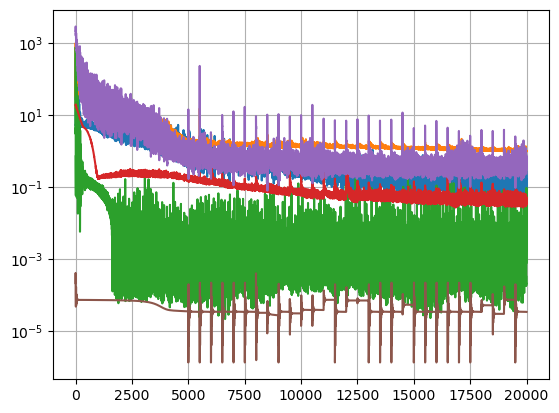

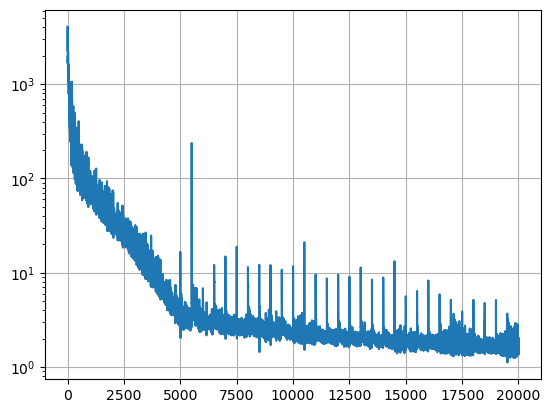

In [42]:
plt.plot(np.r_[ losses2_1])
plt.yscale('log');plt.grid();plt.show()
plt.plot(np.sum(losses2_1,axis=1))
plt.yscale('log');plt.grid();plt.show()

In [43]:
optimizer2.lr.assign(1e-3)
losses2_2 = tu.train(epochs=10000+1,
                  batch_size=H.shape[1]*H.shape[2],#//5,
                  dataset = ds2,#ds.shuffle(H.shape[1]*H.shape[2]),
                  train_step = train_step_inverse2,
                  train_step_returns_num = 6,
                  print_interval=100,
                  loss_sample_interval = 1,
                  stop_threshold=1e-4,
                  print_callback = print_callback2,
                  epoch_callback=epoch_callback1,
                  stop_condition=None)


Start of epoch 0
at epoch 0, total loss: 6.986210716406276, rmse loss: 2.643144096791977
l2_A: 0.20938863, l2_B: 1.01688600, l2_C: 0.00038037, l2_res_A: 0.06827414, l2_res_B: 5.69125175, l2_res_C: 0.00002983
b_A:0: 0.6811925768852234, b_B:0: 19.192508697509766, b_C:0: 0.9033617377281189, V_A:0: 7.875975131988525, V_B:0: 139.5647735595703, V_C:0: 84.36564636230469, K_AA:0: 4.443849563598633, K_AB:0: 0.0008117432007566094, K_AC:0: 29.301830291748047, K_BA:0: 28.9178524017334, K_BC:0: 28.265058517456055, K_CB:0: 1.3938701152801514, K_CC:0: 10.719301223754883
Time taken: 0.38s

Start of epoch 100
at epoch 100, total loss: 1.0061535877975984, rmse loss: 1.0030720750761624
l2_A: 0.01833649, l2_B: 0.89505440, l2_C: 0.00021593, l2_res_A: 0.07542051, l2_res_B: 0.01711448, l2_res_C: 0.00001178
b_A:0: 0.5765148401260376, b_B:0: 19.2213077545166, b_C:0: 0.906197726726532, V_A:0: 7.976834774017334, V_B:0: 139.59458923339844, V_C:0: 84.36579895019531, K_AA:0: 4.4072418212890625, K_AB:0: 0.000804712


Start of epoch 1300
at epoch 1300, total loss: 0.8824879713223481, rmse loss: 0.9394083091618618
l2_A: 0.01385314, l2_B: 0.82035714, l2_C: 0.00003357, l2_res_A: 0.02036686, l2_res_B: 0.02787579, l2_res_C: 0.00000147
b_A:0: 0.05919096618890762, b_B:0: 29.72979736328125, b_C:0: 0.7789250016212463, V_A:0: 8.365427017211914, V_B:0: 17.507568359375, V_C:0: 28.50013542175293, K_AA:0: 4.168306827545166, K_AB:0: 5.382710514822975e-05, K_AC:0: 28.29885482788086, K_BA:0: 29.22969627380371, K_BC:0: 26.650571823120117, K_CB:0: 20.195032119750977, K_CC:0: 6.690222263336182
Time taken: 2.36s

Start of epoch 1400
at epoch 1400, total loss: 0.868795522144751, rmse loss: 0.9320920137758669
l2_A: 0.01235465, l2_B: 0.81472355, l2_C: 0.00003267, l2_res_A: 0.01847719, l2_res_B: 0.02320602, l2_res_C: 0.00000145
b_A:0: 0.04353872686624527, b_B:0: 29.74016761779785, b_C:0: 0.7792801856994629, V_A:0: 8.458639144897461, V_B:0: 17.5179386138916, V_C:0: 28.49994468688965, K_AA:0: 4.208756446838379, K_AB:0: 5.382


Start of epoch 2600
at epoch 2600, total loss: 0.8693938555130671, rmse loss: 0.9324129211422733
l2_A: 0.01587763, l2_B: 0.79128331, l2_C: 0.00001725, l2_res_A: 0.02475761, l2_res_B: 0.03745653, l2_res_C: 0.00000153
b_A:0: 0.0678093358874321, b_B:0: 20.875307083129883, b_C:0: 0.7781949639320374, V_A:0: 8.173178672790527, V_B:0: 26.596420288085938, V_C:0: 28.500516891479492, K_AA:0: 4.061722278594971, K_AB:0: 0.10209140181541443, K_AC:0: 28.29885482788086, K_BA:0: 29.054380416870117, K_BC:0: 26.650190353393555, K_CB:0: 29.95718765258789, K_CC:0: 6.685009479522705
Time taken: 2.35s

Start of epoch 2700
at epoch 2700, total loss: 0.8492216707628586, rmse loss: 0.9215322407614714
l2_A: 0.01396837, l2_B: 0.79001749, l2_C: 0.00001761, l2_res_A: 0.02061622, l2_res_B: 0.02460049, l2_res_C: 0.00000150
b_A:0: 0.07239068299531937, b_B:0: 20.858924865722656, b_C:0: 0.7785646319389343, V_A:0: 8.270370483398438, V_B:0: 26.580087661743164, V_C:0: 28.50032615661621, K_AA:0: 4.126885414123535, K_AB:0:


Start of epoch 3900
at epoch 3900, total loss: 0.8347236142074053, rmse loss: 0.9136321000311916
l2_A: 0.01008496, l2_B: 0.77799767, l2_C: 0.00001456, l2_res_A: 0.01654152, l2_res_B: 0.03008346, l2_res_C: 0.00000145
b_A:0: 0.03380467742681503, b_B:0: 29.72435760498047, b_C:0: 0.779279351234436, V_A:0: 8.458725929260254, V_B:0: 17.50213050842285, V_C:0: 28.499948501586914, K_AA:0: 4.196737766265869, K_AB:0: 5.3828363888897e-05, K_AC:0: 28.29885482788086, K_BA:0: 29.30269432067871, K_BC:0: 26.6507625579834, K_CB:0: 20.19505500793457, K_CC:0: 6.692774295806885
Time taken: 2.43s

Start of epoch 4000
Minimisation

b_A:0.0001, mu_A:1.0000, V_A:8.0748, K_AA:4.0322, K_AB:0.0080, K_AC:28.2989, b_B:0.1517, mu_B:5.0000, V_B:46.8947, K_BA:28.9580, K_BC:26.6500, b_C:0.7783, mu_C:0.5000, V_C:28.5007, K_CB:23.5403, K_CC:6.6822
at epoch 4000, total loss: 0.8309147915136919, rmse loss: 0.9115452767217281
l2_A: 0.01044669, l2_B: 0.77518117, l2_C: 0.00001405, l2_res_A: 0.01549408, l2_res_B: 0.02977738, 


Start of epoch 5200
at epoch 5200, total loss: 0.8224239352394989, rmse loss: 0.9068759205313034
l2_A: 0.01168096, l2_B: 0.76300293, l2_C: 0.00001280, l2_res_A: 0.02080435, l2_res_B: 0.02692140, l2_res_C: 0.00000150
b_A:0: 0.06514887511730194, b_B:0: 0.19967219233512878, b_C:0: 0.7785639762878418, V_A:0: 8.270007133483887, V_B:0: 46.94264221191406, V_C:0: 28.500329971313477, K_AA:0: 4.117125034332275, K_AB:0: 0.060745999217033386, K_AC:0: 28.29885482788086, K_BA:0: 29.14530372619629, K_BC:0: 26.650381088256836, K_CB:0: 23.54445457458496, K_CC:0: 6.68762731552124
Time taken: 2.39s

Start of epoch 5300
at epoch 5300, total loss: 0.8225132109662354, rmse loss: 0.9069251407730604
l2_A: 0.01080564, l2_B: 0.76252550, l2_C: 0.00001165, l2_res_A: 0.01789454, l2_res_B: 0.03127442, l2_res_C: 0.00000147
b_A:0: 0.04716009274125099, b_B:0: 0.21139542758464813, b_C:0: 0.7789244055747986, V_A:0: 8.365178108215332, V_B:0: 46.95439529418945, V_C:0: 28.500139236450195, K_AA:0: 4.155391216278076, K_AB:0


Start of epoch 6500
Minimisation

b_A:0.0001, mu_A:1.0000, V_A:8.0748, K_AA:4.0322, K_AB:0.0006, K_AC:28.2989, b_B:28.0878, mu_B:5.0000, V_B:18.9021, K_BA:28.9580, K_BC:26.6500, b_C:0.7783, mu_C:0.5000, V_C:28.5007, K_CB:28.8170, K_CC:6.6822
at epoch 6500, total loss: 0.8101565549799261, rmse loss: 0.9000869707866713
l2_A: 0.00933322, l2_B: 0.75012493, l2_C: 0.00001037, l2_res_A: 0.01452216, l2_res_B: 0.03616444, l2_res_C: 0.00000142
b_A:0: 6.030446456861682e-05, b_B:0: 28.087818145751953, b_C:0: 0.7782729268074036, V_A:0: 8.074756622314453, V_B:0: 18.9020938873291, V_C:0: 28.500713348388672, K_AA:0: 4.0322136878967285, K_AB:0: 0.0006280952366068959, K_AC:0: 28.29885482788086, K_BA:0: 28.957984924316406, K_BC:0: 26.6500301361084, K_CB:0: 28.817001342773438, K_CC:0: 6.682153224945068
Time taken: 34.90s

Start of epoch 6600
at epoch 6600, total loss: 0.8157246361535044, rmse loss: 0.9031747539394048
l2_A: 0.01434359, l2_B: 0.75457162, l2_C: 0.00001005, l2_res_A: 0.02217800, l2_res_B: 0.


Start of epoch 7800
at epoch 7800, total loss: 0.8155738190147304, rmse loss: 0.9030912573016806
l2_A: 0.00976031, l2_B: 0.74476677, l2_C: 0.00000907, l2_res_A: 0.01671618, l2_res_B: 0.04432002, l2_res_C: 0.00000147
b_A:0: 0.04615205526351929, b_B:0: 20.843950271606445, b_C:0: 0.7789250016212463, V_A:0: 8.364964485168457, V_B:0: 26.565082550048828, V_C:0: 28.500137329101562, K_AA:0: 4.156862735748291, K_AB:0: 0.1351487785577774, K_AC:0: 28.29885482788086, K_BA:0: 29.229238510131836, K_BC:0: 26.650571823120117, K_CB:0: 29.956501007080078, K_CC:0: 6.690222263336182
Time taken: 2.29s

Start of epoch 7900
at epoch 7900, total loss: 0.8026687584844012, rmse loss: 0.8959178302078831
l2_A: 0.00981468, l2_B: 0.74365884, l2_C: 0.00000912, l2_res_A: 0.01441448, l2_res_B: 0.03477019, l2_res_C: 0.00000145
b_A:0: 0.03066636249423027, b_B:0: 20.83310317993164, b_C:0: 0.7792803645133972, V_A:0: 8.457192420959473, V_B:0: 26.554264068603516, V_C:0: 28.49994659423828, K_AA:0: 4.195279121398926, K_AB:0:


Start of epoch 9100
at epoch 9100, total loss: 0.808025222849551, rmse loss: 0.8989022320861991
l2_A: 0.01303657, l2_B: 0.73929775, l2_C: 0.00000913, l2_res_A: 0.02248899, l2_res_B: 0.03319125, l2_res_C: 0.00000153
b_A:0: 0.06467305123806, b_B:0: 0.0011471399338915944, b_C:0: 0.7781950235366821, V_A:0: 8.173095703125, V_B:0: 47.34712219238281, V_C:0: 28.500518798828125, K_AA:0: 4.060234546661377, K_AB:0: 0.06851831823587418, K_AC:0: 28.29885482788086, K_BA:0: 29.054241180419922, K_BC:0: 26.650190353393555, K_CB:0: 29.414175033569336, K_CC:0: 6.685009956359863
Time taken: 2.36s

Start of epoch 9200
at epoch 9200, total loss: 0.8022757560183891, rmse loss: 0.8956984738283241
l2_A: 0.01212451, l2_B: 0.74115705, l2_C: 0.00000812, l2_res_A: 0.01791766, l2_res_B: 0.03106691, l2_res_C: 0.00000150
b_A:0: 0.06120260804891586, b_B:0: 0.0008435383788309991, b_C:0: 0.7785645127296448, V_A:0: 8.26977252960205, V_B:0: 47.335784912109375, V_C:0: 28.500328063964844, K_AA:0: 4.116631507873535, K_AB:0:

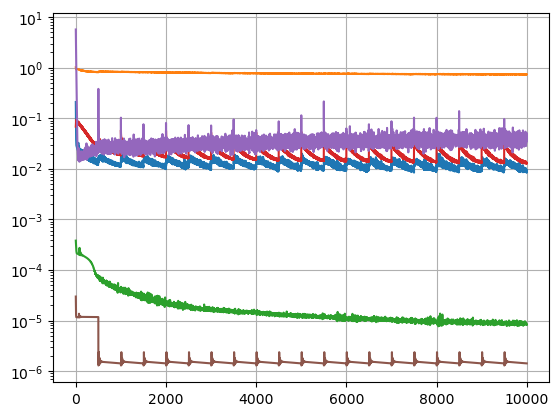

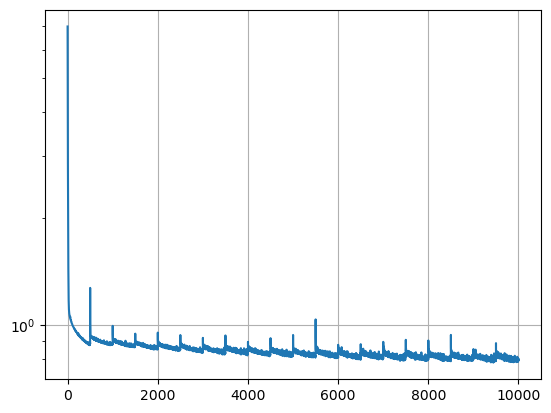

In [44]:
plt.plot(np.r_[ losses2_2])
plt.yscale('log');plt.grid();plt.show()
plt.plot(np.sum(losses2_2,axis=1))
plt.yscale('log');plt.grid();plt.show()

In [45]:
optimizer2.lr.assign(1e-4)
losses2_3 = tu.train(epochs=10000+1,
                  batch_size=H.shape[1]*H.shape[2],#//5,
                  dataset = ds2,#ds.shuffle(H.shape[1]*H.shape[2]),
                  train_step = train_step_inverse2,
                  train_step_returns_num = 6,
                  print_interval=100,
                  loss_sample_interval = 1,
                  stop_threshold=1e-4,
                  print_callback = print_callback2,
                  epoch_callback=None,
                  stop_condition=None)


Start of epoch 0
at epoch 0, total loss: 0.9466055770931234, rmse loss: 0.9729365740340546
l2_A: 0.00845405, l2_B: 0.73172194, l2_C: 0.00000840, l2_res_A: 0.05057961, l2_res_B: 0.15584029, l2_res_C: 0.00000129
b_A:0: 0.0003763209097087383, b_B:0: 4.5596818923950195, b_C:0: 0.7782799005508423, V_A:0: 8.07507038116455, V_B:0: 42.323368072509766, V_C:0: 28.500713348388672, K_AA:0: 4.031902313232422, K_AB:0: 0.03513519465923309, K_AC:0: 28.29885482788086, K_BA:0: 28.958288192749023, K_BC:0: 26.6500301361084, K_CB:0: 18.622970581054688, K_CC:0: 6.682153224945068
Time taken: 0.14s

Start of epoch 100
at epoch 100, total loss: 0.7913573252095603, rmse loss: 0.8895826691261247
l2_A: 0.01183469, l2_B: 0.73592198, l2_C: 0.00000713, l2_res_A: 0.03314865, l2_res_B: 0.01044360, l2_res_C: 0.00000129
b_A:0: 0.010770329274237156, b_B:0: 4.567418575286865, b_C:0: 0.7783460021018982, V_A:0: 8.085512161254883, V_B:0: 42.331092834472656, V_C:0: 28.500713348388672, K_AA:0: 4.021444320678711, K_AB:0: 0.038


Start of epoch 1500
at epoch 1500, total loss: 0.7588566753679515, rmse loss: 0.871123800253415
l2_A: 0.01073786, l2_B: 0.71797407, l2_C: 0.00000741, l2_res_A: 0.01948615, l2_res_B: 0.01064993, l2_res_C: 0.00000125
b_A:0: 0.07645361870527267, b_B:0: 4.670231342315674, b_C:0: 0.7789025902748108, V_A:0: 8.224507331848145, V_B:0: 42.434051513671875, V_C:0: 28.500713348388672, K_AA:0: 4.106372356414795, K_AB:0: 0.14520420134067535, K_AC:0: 28.29885482788086, K_BA:0: 29.101842880249023, K_BC:0: 26.6500301361084, K_CB:0: 18.631704330444336, K_CC:0: 6.686435699462891
Time taken: 3.16s

Start of epoch 1600
at epoch 1600, total loss: 0.7576991402722797, rmse loss: 0.8704591548558035
l2_A: 0.01038704, l2_B: 0.71747798, l2_C: 0.00000742, l2_res_A: 0.01933111, l2_res_B: 0.01049434, l2_res_C: 0.00000125
b_A:0: 0.07440627366304398, b_B:0: 4.675277233123779, b_C:0: 0.7789422273635864, V_A:0: 8.234477043151855, V_B:0: 42.43910598754883, V_C:0: 28.500713348388672, K_AA:0: 4.110240936279297, K_AB:0: 0.


Start of epoch 3000
at epoch 3000, total loss: 0.7466668230282494, rmse loss: 0.864098850264395
l2_A: 0.00889157, l2_B: 0.71077615, l2_C: 0.00000752, l2_res_A: 0.01521559, l2_res_B: 0.01177479, l2_res_C: 0.00000121
b_A:0: 0.046663448214530945, b_B:0: 4.719788074493408, b_C:0: 0.7794970870018005, V_A:0: 8.37397289276123, V_B:0: 42.483642578125, V_C:0: 28.500713348388672, K_AA:0: 4.165381908416748, K_AB:0: 0.1609877347946167, K_AC:0: 28.29885482788086, K_BA:0: 29.234905242919922, K_BC:0: 26.6500301361084, K_CB:0: 18.632484436035156, K_CC:0: 6.690727233886719
Time taken: 3.15s

Start of epoch 3100
at epoch 3100, total loss: 0.7461820917212663, rmse loss: 0.8638183210150536
l2_A: 0.00893343, l2_B: 0.71051776, l2_C: 0.00000752, l2_res_A: 0.01485541, l2_res_B: 0.01186677, l2_res_C: 0.00000121
b_A:0: 0.04501132667064667, b_B:0: 4.721157073974609, b_C:0: 0.7795366644859314, V_A:0: 8.38392448425293, V_B:0: 42.48501205444336, V_C:0: 28.500713348388672, K_AA:0: 4.169528007507324, K_AB:0: 0.16151


Start of epoch 4400
at epoch 4400, total loss: 0.7392318408936944, rmse loss: 0.8597859273643029
l2_A: 0.00784229, l2_B: 0.70608050, l2_C: 0.00000762, l2_res_A: 0.01302660, l2_res_B: 0.01227366, l2_res_C: 0.00000117
b_A:0: 0.02553839422762394, b_B:0: 4.737948894500732, b_C:0: 0.7800502777099609, V_A:0: 8.513007164001465, V_B:0: 42.50175857543945, V_C:0: 28.500713348388672, K_AA:0: 4.224833011627197, K_AB:0: 0.1681736409664154, K_AC:0: 28.29885482788086, K_BA:0: 29.326772689819336, K_BC:0: 26.6500301361084, K_CB:0: 18.632272720336914, K_CC:0: 6.694732666015625
Time taken: 2.67s

Start of epoch 4500
at epoch 4500, total loss: 0.7392145542224853, rmse loss: 0.8597758744129107
l2_A: 0.00774881, l2_B: 0.70589876, l2_C: 0.00000762, l2_res_A: 0.01296476, l2_res_B: 0.01259343, l2_res_C: 0.00000117
b_A:0: 0.02434428408741951, b_B:0: 4.738615036010742, b_C:0: 0.7800897359848022, V_A:0: 8.52288818359375, V_B:0: 42.502410888671875, V_C:0: 28.500713348388672, K_AA:0: 4.229151248931885, K_AB:0: 0.1


Start of epoch 5900
at epoch 5900, total loss: 0.7337449489333494, rmse loss: 0.8565891365954563
l2_A: 0.00713983, l2_B: 0.70214313, l2_C: 0.00000773, l2_res_A: 0.01247868, l2_res_B: 0.01197445, l2_res_C: 0.00000113
b_A:0: 0.015103856101632118, b_B:0: 4.746848106384277, b_C:0: 0.7806411385536194, V_A:0: 8.633774757385254, V_B:0: 42.510398864746094, V_C:0: 28.500713348388672, K_AA:0: 4.281844615936279, K_AB:0: 0.17408040165901184, K_AC:0: 28.29885482788086, K_BA:0: 29.331073760986328, K_BC:0: 26.6500301361084, K_CB:0: 18.631711959838867, K_CC:0: 6.699024200439453
Time taken: 3.18s

Start of epoch 6000
at epoch 6000, total loss: 0.7333924675257322, rmse loss: 0.8563833648114214
l2_A: 0.00708104, l2_B: 0.70173377, l2_C: 0.00000772, l2_res_A: 0.01246410, l2_res_B: 0.01210471, l2_res_C: 0.00000113
b_A:0: 0.015267718583345413, b_B:0: 4.747379302978516, b_C:0: 0.7806804776191711, V_A:0: 8.6355619430542, V_B:0: 42.51091384887695, V_C:0: 28.500713348388672, K_AA:0: 4.283105850219727, K_AB:0: 0


Start of epoch 7400
at epoch 7400, total loss: 0.7303861712614435, rmse loss: 0.8546263342896961
l2_A: 0.00692117, l2_B: 0.69789016, l2_C: 0.00000773, l2_res_A: 0.01228683, l2_res_B: 0.01327919, l2_res_C: 0.00000109
b_A:0: 0.015815507620573044, b_B:0: 4.752030372619629, b_C:0: 0.7812302112579346, V_A:0: 8.651004791259766, V_B:0: 42.5151481628418, V_C:0: 28.500713348388672, K_AA:0: 4.291814804077148, K_AB:0: 0.1791914701461792, K_AC:0: 28.29885482788086, K_BA:0: 29.296424865722656, K_BC:0: 26.6500301361084, K_CB:0: 18.630998611450195, K_CC:0: 6.703315734863281
Time taken: 3.15s

Start of epoch 7500
at epoch 7500, total loss: 0.7308249604453749, rmse loss: 0.8548830098003907
l2_A: 0.00690820, l2_B: 0.69767451, l2_C: 0.00000773, l2_res_A: 0.01228254, l2_res_B: 0.01395089, l2_res_C: 0.00000109
b_A:0: 0.015721537172794342, b_B:0: 4.7522430419921875, b_C:0: 0.781269371509552, V_A:0: 8.651640892028809, V_B:0: 42.51535415649414, V_C:0: 28.500713348388672, K_AA:0: 4.292238712310791, K_AB:0: 0.


Start of epoch 8900
at epoch 8900, total loss: 0.7271372666808702, rmse loss: 0.8527234409120404
l2_A: 0.00686161, l2_B: 0.69471920, l2_C: 0.00000771, l2_res_A: 0.01211399, l2_res_B: 0.01343370, l2_res_C: 0.00000106
b_A:0: 0.015574813820421696, b_B:0: 4.755588531494141, b_C:0: 0.7818173766136169, V_A:0: 8.660346984863281, V_B:0: 42.51823425292969, V_C:0: 28.500713348388672, K_AA:0: 4.296599388122559, K_AB:0: 0.18380378186702728, K_AC:0: 28.29885482788086, K_BA:0: 29.2614803314209, K_BC:0: 26.6500301361084, K_CB:0: 18.630285263061523, K_CC:0: 6.707607269287109
Time taken: 3.03s

Start of epoch 9000
at epoch 9000, total loss: 0.7267014312342326, rmse loss: 0.8524678476249017
l2_A: 0.00686683, l2_B: 0.69473481, l2_C: 0.00000771, l2_res_A: 0.01209269, l2_res_B: 0.01299833, l2_res_C: 0.00000105
b_A:0: 0.01574760302901268, b_B:0: 4.755810737609863, b_C:0: 0.7818564176559448, V_A:0: 8.6607666015625, V_B:0: 42.5184211730957, V_C:0: 28.500713348388672, K_AA:0: 4.29679012298584, K_AB:0: 0.18413

In [50]:
params

{'D_A': 0.01,
 'D_B': 1.0,
 'n': 4.0,
 'b_A': 0.001,
 'mu_A': 1.0,
 'V_A': 20.0,
 'K_AA': 5.0,
 'K_AB': 5.0,
 'K_AC': 10.0,
 'b_B': 0.1,
 'mu_B': 5.0,
 'V_B': 100.0,
 'K_BA': 10.0,
 'K_BC': 5.0,
 'b_C': 1.0,
 'mu_C': 0.5,
 'V_C': 100.0,
 'K_CB': 10.0,
 'K_CC': 10.0}

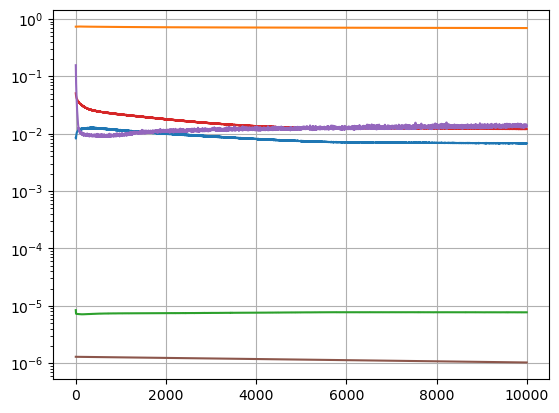

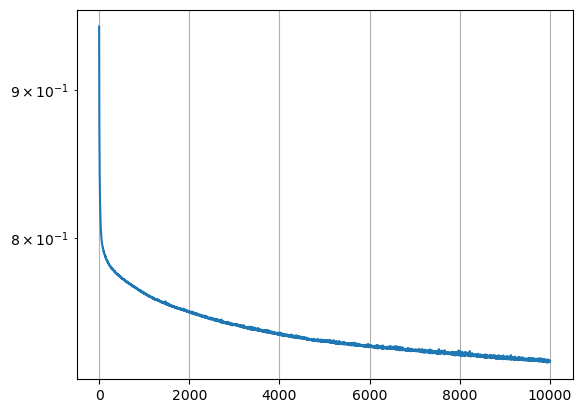

In [46]:
plt.plot(np.r_[ losses2_3])
plt.yscale('log');plt.grid();plt.show()
plt.plot(np.sum(losses2_3,axis=1))
plt.yscale('log');plt.grid();plt.show()

In [ ]:
params_shm = shared_memory.SharedMemory(name="params_by_theta")
output_shm = shared_memory.SharedMemory(name="outputs")

params_shm.close()
params_shm.unlink()

output_shm.close()
output_shm.unlink()